In [1]:
import sys
import os
import numpy as np

# Thêm đường dẫn đến thư mục src để import các module
sys.path.append(os.path.abspath(os.path.join('..')))

from src import data_processing as dp
from src import visualization as viz

# Cấu hình để hiển thị biểu đồ trong notebook
%matplotlib inline

# Tải dữ liệu
filepath = '../data/raw/aug_train.csv'
data = dp.load_data(filepath)

---

# 1. Tổng Quan Dữ Liệu

### 1.1. Thông tin cơ bản

In [2]:
basic_info = dp.get_basic_info(data)
print(f"Số dòng: {basic_info['shape'][0]}")
print(f"Số cột: {basic_info['shape'][1]}")
print(f"Kích thước tổng thể: {basic_info['memory_usage'] / 1e6:.2f} MB")

Số dòng: 19158
Số cột: 14
Kích thước tổng thể: 9.66 MB


**Mỗi dòng trong tập dữ liệu này đại diện cho một ứng viên đã đăng ký tham gia chương trình đào tạo của công ty.**
Dòng dữ liệu mô tả đầy đủ hồ sơ của từng ứng viên, bao gồm thông tin nhân khẩu học, trình độ học vấn, kinh nghiệm làm việc, tình trạng công việc hiện tại, số giờ đào tạo và một biến mục tiêu cho biết họ có đang tìm kiếm cơ hội việc làm mới hay có khả năng gắn bó làm việc cho công ty sau khi hoàn thành khóa đào tạo.


In [3]:
# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên:")
print(data[:5])

# Hiển thị 5 dòng cuối cùng
print("\n5 dòng cuối cùng:")
print(data[-5:])

5 dòng đầu tiên:
[( 8949, 'city_103', 0.92 , 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', 36, 1.)
 (29725, 'city_40', 0.776, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', 47, 0.)
 (11561, 'city_21', 0.624, '', 'No relevent experience', 'Full time course', 'Graduate', 'STEM', '5', '', '', 'never', 83, 0.)
 (33241, 'city_115', 0.789, '', 'No relevent experience', '', 'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never', 52, 1.)
 (  666, 'city_162', 0.767, 'Male', 'Has relevent experience', 'no_enrollment', 'Masters', 'STEM', '>20', '50-99', 'Funded Startup', '4',  8, 0.)]

5 dòng cuối cùng:
[( 7386, 'city_173', 0.878, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'Humanities', '14', '', '', '1',  42, 1.)
 (31398, 'city_103', 0.92 , 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '14', '', '', '4',  52, 1.)
 (24576, 'city_103', 0.92 , 'Mal

### 1.2. Tính toàn vẹn của dữ liệu

In [4]:
duplicate_info = dp.check_duplicates(data)
print(f"Số dòng trùng lặp (không tính enrollee_id): {duplicate_info['duplicated_rows']}")
print(f"Tỷ lệ trùng lặp: {duplicate_info['duplicated_percentage']:.2f}%")

Số dòng trùng lặp (không tính enrollee_id): 49
Tỷ lệ trùng lặp: 0.26%


In [5]:
# Hiển thị các dòng trùng lặp nếu có
if duplicate_info['duplicated_rows'] > 0:
    print("\nCác dòng được xác định là trùng lặp:")
    for duplicate in duplicate_info['representative_duplicates']:
        print(duplicate['row'])
        print(f"Count: {duplicate['count']}")
        print()
else:
    print("\nKhông tìm thấy dòng nào trùng lặp.")


Các dòng được xác định là trùng lặp:
(9645, 'city_16', 0.91, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '', '', '>4', 47, 0.)
Count: 2

(22319, 'city_21', 0.624, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '<1', '', '', '1', 14, 1.)
Count: 2

(20376, 'city_160', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '>4', 25, 1.)
Count: 2

(5911, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '100-500', 'Pvt Ltd', '>4', 151, 0.)
Count: 2

(440, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Masters', 'STEM', '>20', '10000+', 'Pvt Ltd', '>4', 42, 0.)
Count: 2

(14361, 'city_103', 0.92, 'Male', 'No relevent experience', 'no_enrollment', 'High School', '', '4', '', '', 'never', 21, 0.)
Count: 2

(31595, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '1000-4999', 'Pvt 

**Xử lý dữ liệu trùng lặp:**

Các dòng trùng lặp **nên được loại bỏ**.

Toàn bộ 49 bản ghi trùng đều xuất hiện **dưới dạng cặp giống hệt nhau trên tất cả các thuộc tính trừ `enrollee_id`**. Điều này cho thấy những bản ghi này thực chất mô tả **cùng một ứng viên** được ghi nhận nhiều lần, không mang thêm thông tin mới.

Tỷ lệ trùng lặp tuy nhỏ (**0.26%**) nhưng việc loại bỏ vẫn cần thiết để đảm bảo dữ liệu **sạch**, tránh tác động tiêu cực đến mô hình dự báo.

In [6]:
# Có bao nhiêu dòng hoàn toàn đủ/trống thông tin
row_completeness = dp.count_row_completeness(data)
print(f"Số dòng đủ hết thông tin: {row_completeness['complete_rows']}")
print(f"Số dòng thiếu hết thông tin: {row_completeness['empty_rows']}")

Số dòng đủ hết thông tin: 8955
Số dòng thiếu hết thông tin: 0


### 1.3. Thông tin cột và kiểu dữ liệu

**Ý nghĩa của từng cột:**

- **enrollee_id**: ID duy nhất cho ứng viên.
- **city**: Mã thành phố.
- **city_development_index**: Chỉ số phát triển của thành phố (đã được scale).
- **gender**: Giới tính của ứng viên.
- **relevent_experience**: Kinh nghiệm liên quan của ứng viên.
- **enrolled_university**: Loại khóa học đại học đã đăng ký (nếu có).
- **education_level**: Trình độ học vấn của ứng viên.
- **major_discipline**: Chuyên ngành học chính của ứng viên.
- **experience**: Tổng số năm kinh nghiệm.
- **company_size**: Số lượng nhân viên trong công ty của nhà tuyển dụng hiện tại.
- **company_type**: Loại hình của nhà tuyển dụng hiện tại.
- **last_new_job**: Chênh lệch số năm giữa công việc trước đó và công việc hiện tại.
- **training_hours**: Số giờ đào tạo đã hoàn thành.
- **target**: Biến mục tiêu.
  - `0`: Không tìm kiếm sự thay đổi công việc.
  - `1`: Đang tìm kiếm sự thay đổi công việc.

**Các cột có liên quan và các cột cần loại bỏ:**

- **Cột cần loại bỏ:** `enrollee_id` là một mã định danh duy nhất và không có giá trị dự đoán. Nó nên được loại bỏ khỏi quá trình huấn luyện mô hình.
- **Các cột liên quan:** Tất cả các cột khác đều có khả năng chứa thông tin hữu ích để dự đoán biến mục tiêu `target`.

In [7]:
print("Kiểu dữ liệu của các cột:")
for name, dtype in basic_info['dtypes'].items():
    print(f"- {name}: {dtype}")

Kiểu dữ liệu của các cột:
- enrollee_id: int64
- city: <U8
- city_development_index: float64
- gender: <U6
- relevent_experience: <U23
- enrolled_university: <U16
- education_level: <U14
- major_discipline: <U15
- experience: <U3
- company_size: <U9
- company_type: <U19
- last_new_job: <U5
- training_hours: int64
- target: float64


**Ghi chú kiểu dữ liệu `<U...`:**

Khi đọc dữ liệu từ file CSV bằng **NumPy** (ví dụ dùng `np.loadtxt` hoặc `np.genfromtxt`), các cột chứa dữ liệu dạng chữ sẽ được NumPy chuyển thành kiểu **chuỗi Unicode** với định dạng **`<U...`**. Ký hiệu này thể hiện kiểu *Unicode string* có độ dài cố định, trong đó số phía sau (ví dụ `<U8`, `<U23`, ...) là **độ dài tối đa của chuỗi trong cột**. Khi NumPy gặp cột chứa ký tự, nó không có kiểu linh hoạt như `object` của pandas, do đó nó buộc phải chọn một kiểu chuỗi Unicode có độ dài đủ lớn để chứa giá trị dài nhất trong cột. 

---

# 2. Phân Tích Giá Trị Thiếu

### 2.1. Đánh giá tổng quan 

In [8]:
missing_summary = dp.get_missing_summary(data)
print("Tóm tắt giá trị thiếu theo từng cột:")
for col, summary in missing_summary.items():
    if summary['missing_count'] > 0:
        print(f"- Cột '{col}': {summary['missing_count']} giá trị thiếu ({summary['missing_percentage']:.2f}%)")

Tóm tắt giá trị thiếu theo từng cột:
- Cột 'company_type': 6140 giá trị thiếu (32.05%)
- Cột 'company_size': 5938 giá trị thiếu (30.99%)
- Cột 'gender': 4508 giá trị thiếu (23.53%)
- Cột 'major_discipline': 2813 giá trị thiếu (14.68%)
- Cột 'education_level': 460 giá trị thiếu (2.40%)
- Cột 'last_new_job': 423 giá trị thiếu (2.21%)
- Cột 'enrolled_university': 386 giá trị thiếu (2.01%)
- Cột 'experience': 65 giá trị thiếu (0.34%)


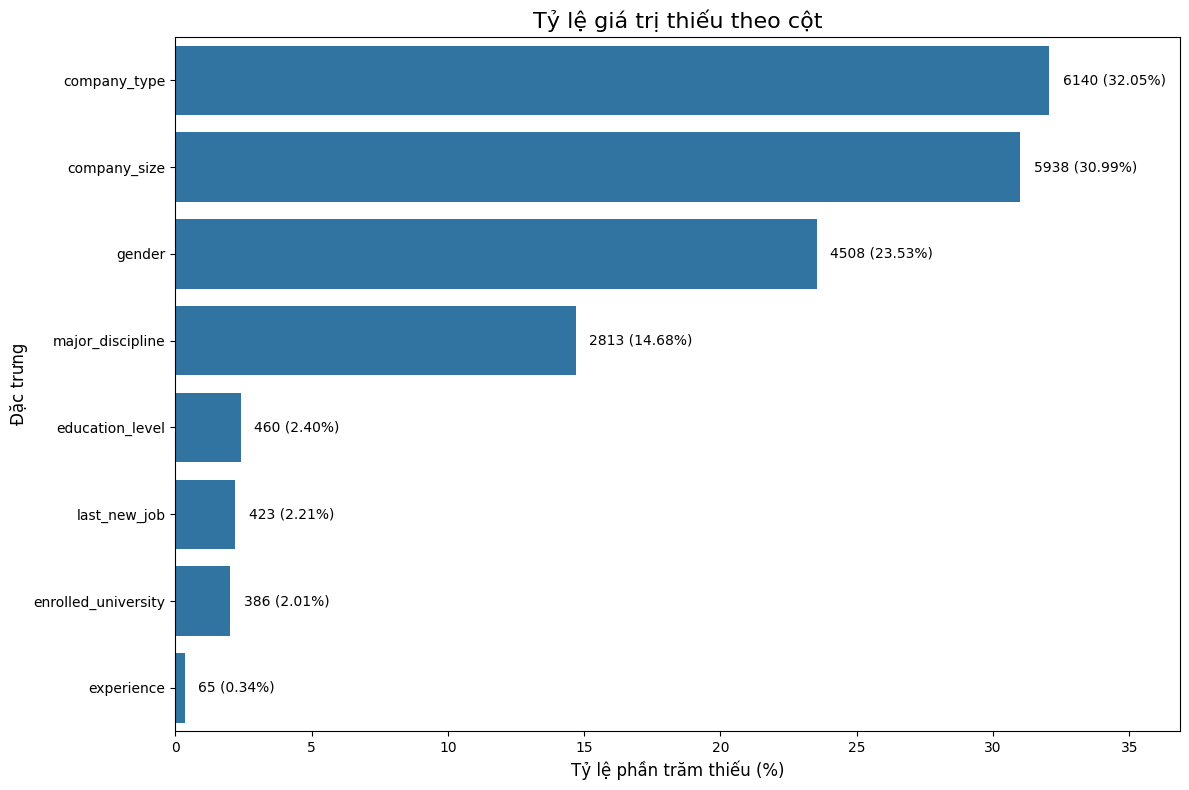

In [9]:
viz.plot_missing_summary(missing_summary)

**Nhận xét:**

**Missing values không random mà có thể có pattern:**
- Các biến liên quan đến **công ty hiện tại** có tỷ lệ thiếu cao nhất và gần như tương đương nhau: `company_type` (32.05%) và `company_size` (30.99%), cho thấy chúng thường thiếu đồng thời
- Biến `gender` (23.53%) và `major_discipline` (14.68%) có tỷ lệ thiếu vừa phải
- Các biến còn lại có tỷ lệ thiếu rất thấp (<3%)

### 2.2. Tỉ lệ target cho trạng thái giá trị thiếu

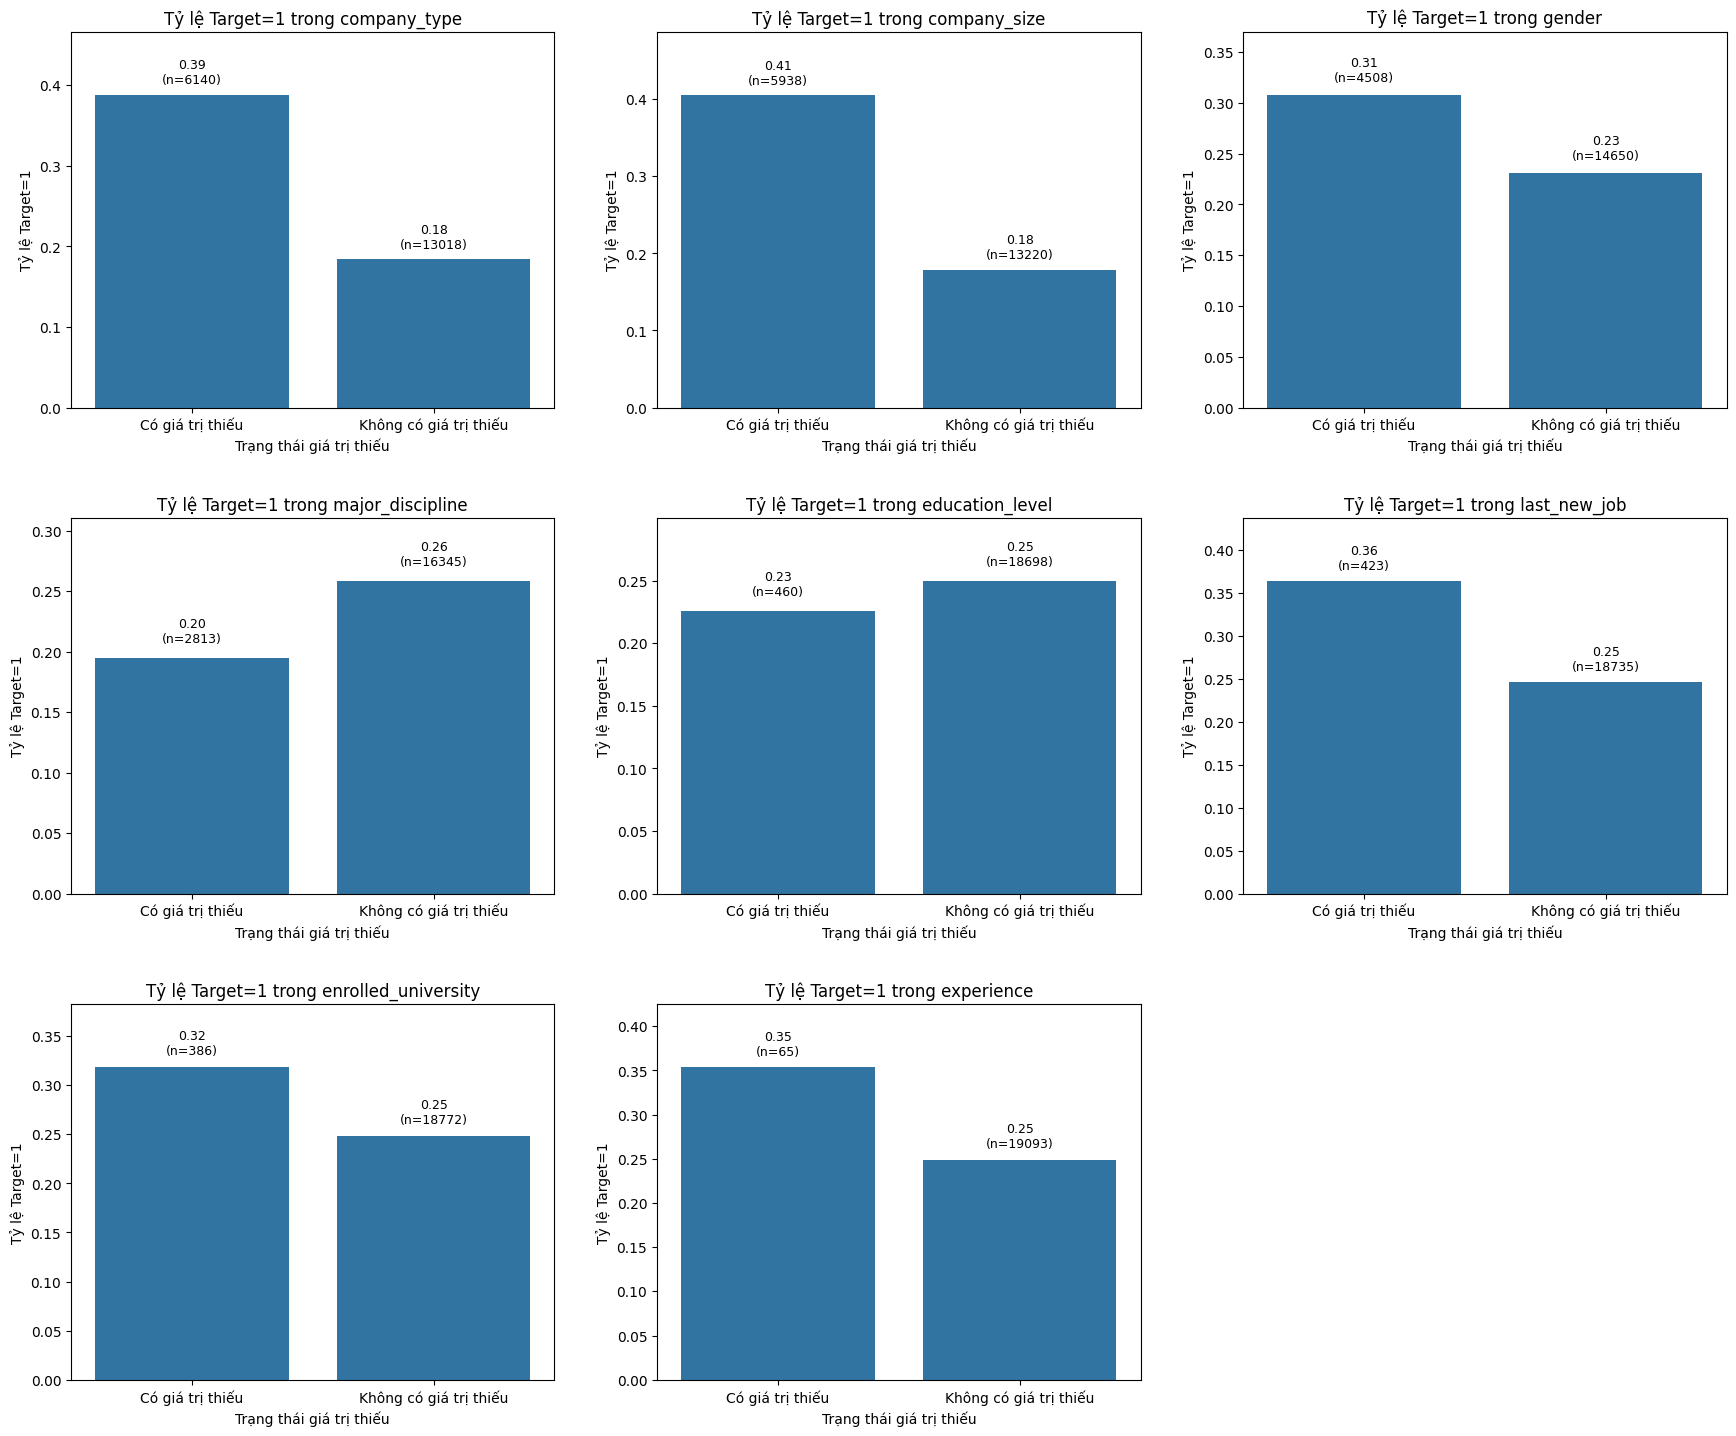

In [10]:
cols_to_compare = [col for col, summary in missing_summary.items() if 0 < summary['missing_percentage'] < 50]
viz.plot_target_rate_by_missing_grid(data, cols_to_compare)

**Nhận xét:**

Phân tích tỷ lệ `target=1` (tìm kiếm việc mới) giữa nhóm có và không có giá trị thiếu cho thấy những khác biệt đáng chú ý:

**Các biến có sự khác biệt lớn:**
- **company_type**: Nhóm có giá trị thiếu có tỷ lệ target=1 cao hơn đáng kể (0.39 so với 0.18), chênh lệch gấp hơn 2 lần. Điều này cho thấy việc thiếu thông tin về loại hình công ty có thể liên quan chặt chẽ đến xu hướng tìm việc mới.
- **company_size**: Tương tự, nhóm thiếu dữ liệu có tỷ lệ target=1 cao hơn (0.41 so với 0.18), thể hiện mối liên hệ mạnh mẽ giữa việc không cung cấp thông tin quy mô công ty và ý định chuyển việc.

**Các biến có sự khác biệt vừa phải:**
- **last_new_job**: Chênh lệch tương đối với tỷ lệ 0.36 so với 0.25 cho thấy những người không tiết lộ thời gian công việc gần nhất có xu hướng tìm việc cao hơn.
- **gender**: Chênh lệch tương đối (0.31 so với 0.23), cho thấy việc thiếu thông tin giới tính cũng có liên quan đến hành vi tìm việc.
- **enrolled_university**: Nhóm thiếu dữ liệu có tỷ lệ 0.32 so với 0.25, phản ánh khả năng những người không cung cấp thông tin học vấn có động cơ tìm việc mạnh hơn.
- **experience**: Tỷ lệ 0.35 so với 0.25 mặc dù số lượng quan sát thiếu rất nhỏ (n=65).

**Các biến có sự khác biệt nhỏ:**
- **education_level** và **major_discipline**: Chênh lệch không đáng kể giữa hai nhóm (0.23 vs 0.25 và 0.20 vs 0.26), cho thấy việc thiếu dữ liệu ở các biến này ít tác động đến biến mục tiêu.

**Kết luận:**
Bản thân việc thiếu dữ liệu, đặc biệt ở các biến liên quan đến thông tin công ty hiện tại (company_type, company_size) có thể là một **tín hiệu dự báo mạnh mẽ** cho xu hướng tìm kiếm việc làm mới. 

---

# 3. Phân Tích Đơn Biến

### 3.1. Phân tích biến mục tiêu 

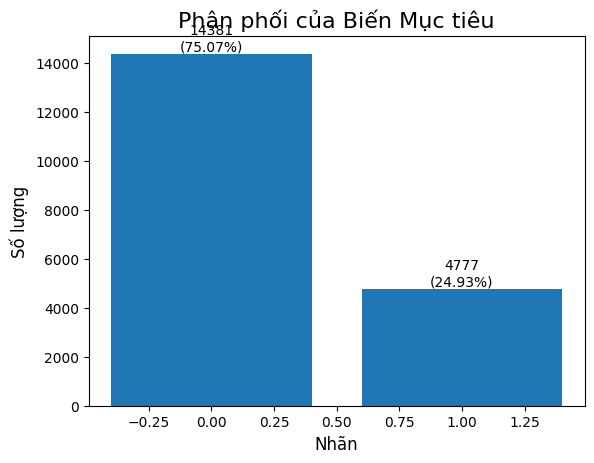

In [11]:
target_dist = dp.get_target_distribution(data)
viz.plot_target_distribution(target_dist['counts'], target_dist['percentages'])

**Nhận xét:**

- Tập dữ liệu bị **mất cân bằng nghiêm trọng** với lớp `target=0.0` chiếm đa số (khoảng 75%) so với lớp `target=1.0` (khoảng 25%). Tỷ lệ này là khoảng 3:1. Điều này cần được xử lý trong giai đoạn mô hình hóa.
- Tập dữ liệu có **nhãn nhị phân**, hiện tại đang được biểu diễn là `0.0` và `1.0`, cần đổi về dạng `int` là `0` và `1`. 

### 3.2. Phân tích các biến numerical

In [12]:
numerical_cols = [name for name, dtype in data.dtype.fields.items() if np.issubdtype(dtype[0], np.number)]
numerical_cols.remove('enrollee_id')
if 'target' in numerical_cols:
    numerical_cols.remove('target')
print(f"Các biến số ({len(numerical_cols)}): {numerical_cols}")

Các biến số (2): ['city_development_index', 'training_hours']


#### a. Phân phối và xu hướng trung tâm

In [13]:
numerical_summary = dp.get_numerical_summary(data, numerical_cols)
for col, summary in numerical_summary.items():
    print(f"Thống kê mô tả cho cột '{col}':")
    for stat, value in summary.items():
        print(f"  {stat:<10} {value:>10.2f}")

Thống kê mô tả cho cột 'city_development_index':
  count        19158.00
  mean             0.83
  std              0.12
  min              0.45
  25%              0.74
  50%              0.90
  75%              0.92
  max              0.95
Thống kê mô tả cho cột 'training_hours':
  count        19158.00
  mean            65.37
  std             60.06
  min              1.00
  25%             23.00
  50%             47.00
  75%             88.00
  max            336.00


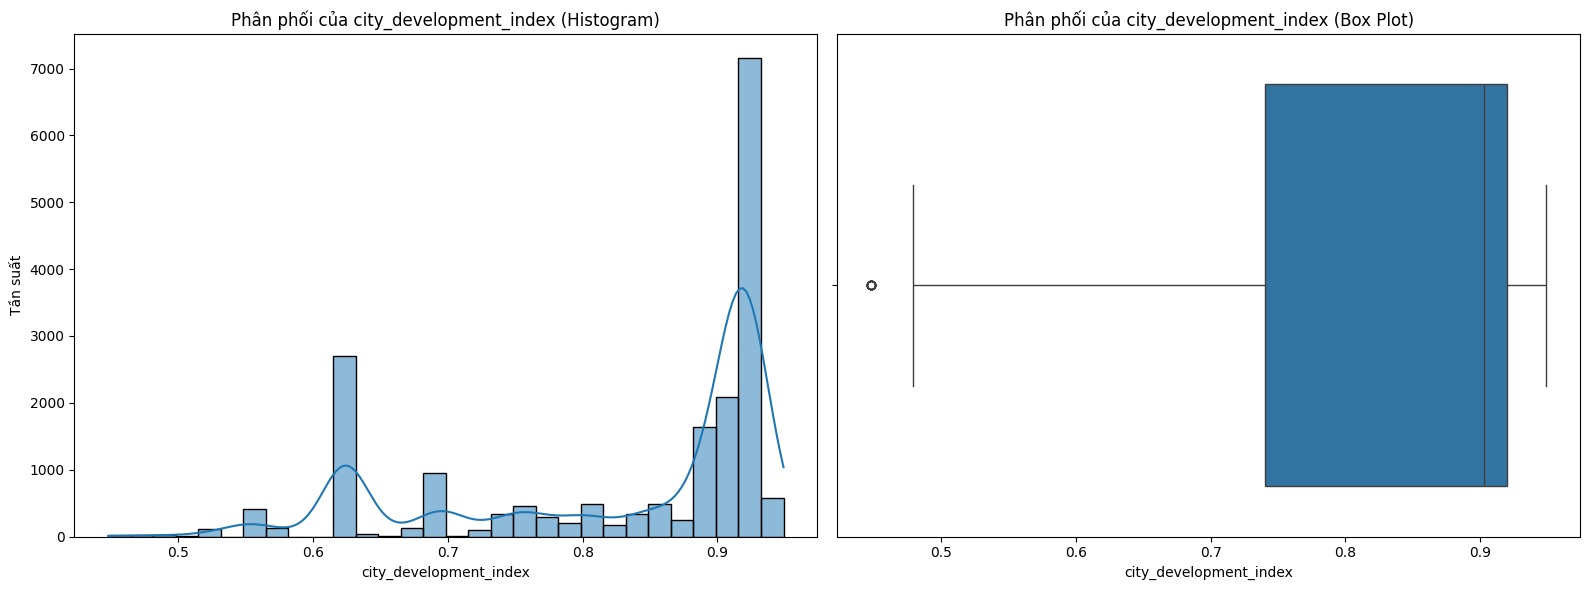

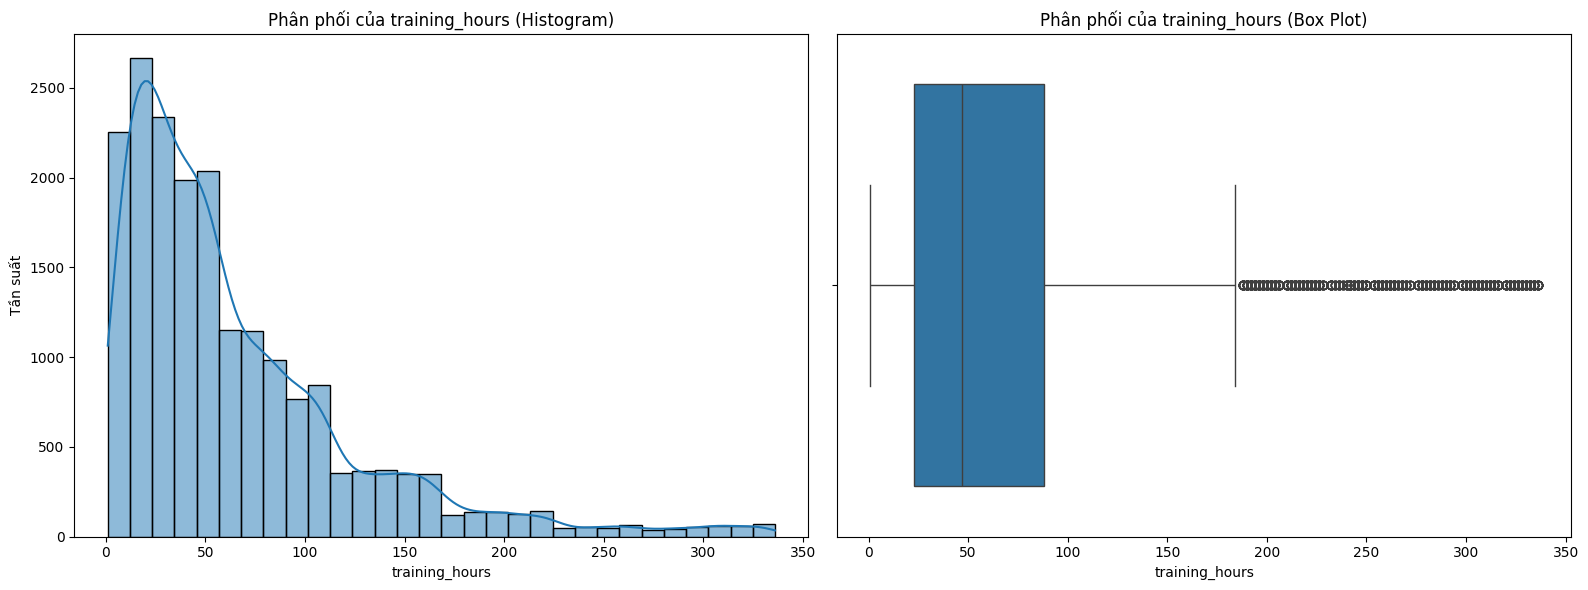

In [14]:
for col in numerical_cols:
    viz.plot_numerical_distribution_and_boxplot(data, col)

**Phân phối:**
- **`city_development_index`**: Phân phối multimodal với hai đỉnh rõ rệt tại ~0.62 và ~0.92. Đa số ứng viên (>70%) đến từ các thành phố có chỉ số phát triển cao (>0.9), phản ánh việc hầu hết các công ty tuyển dụng đều đến từ các đô thị lớn.
- **`training_hours`**: Phân phối lệch phải mạnh, đỉnh tập trung ở 20-40 giờ. Khoảng 70-80% ứng viên hoàn thành dưới 100 giờ đào tạo, cho thấy đa số chỉ tham gia các khóa học ngắn.

**Outliers:**
- **`city_development_index`**: Có một số outliers ở phía giá trị thấp (<0.5), đại diện cho các thành phố kém phát triển. Số lượng ít nên có thể giữ lại hoặc xử lý riêng tùy theo phân tích sâu hơn.
- **`training_hours`**: Có rất nhiều outliers ở phía trên (>~180 giờ), thể hiện nhóm ứng viên có cam kết cao với việc học.

#### b. Tương quan giữa biến numerical và target

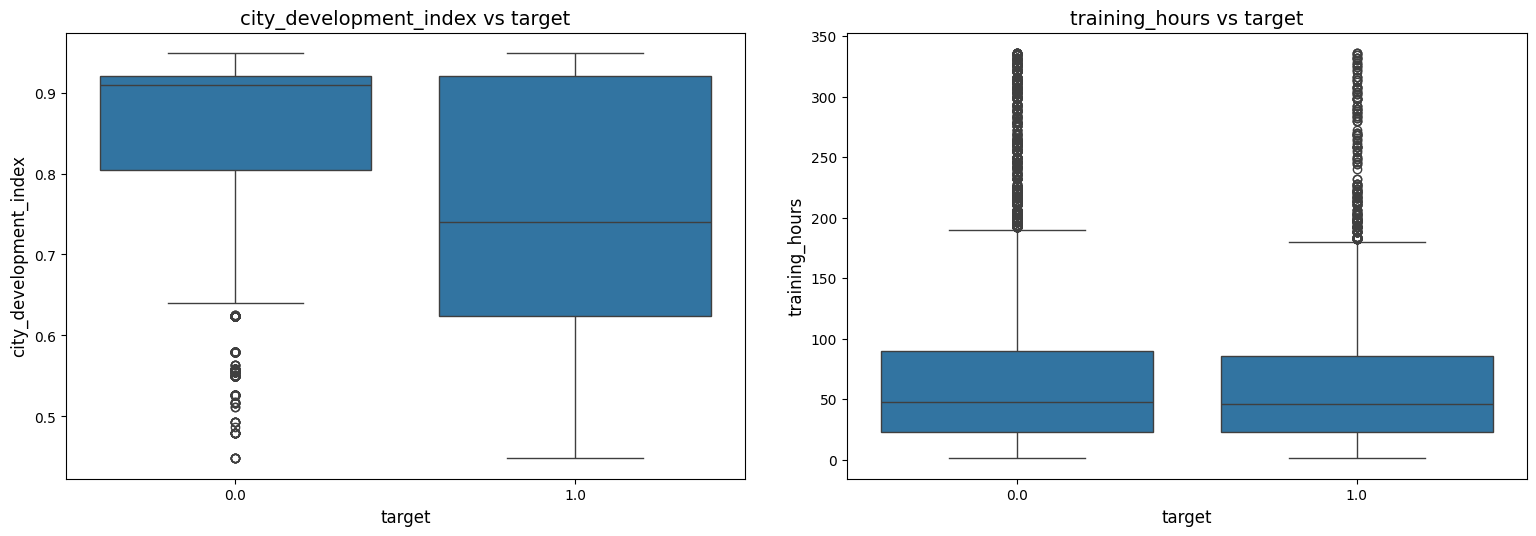

In [15]:
viz.plot_numerical_vs_target_grid(data, numerical_cols)

- **`city_development_index`**

  * Nhóm **target = 1** có **độ phân tán lớn hơn** (IQR rộng hơn) so với nhóm target = 0.
  * **Median của target = 1 thấp hơn đáng kể** so với target = 0.
  * Nhóm **target = 0** có phân phối tập trung hơn ở mức **cao hơn ~0.9**, trong khi nhóm target = 1 trải rộng từ thấp đến cao.

  **$\Rightarrow$ Ứng viên từ các thành phố kém phát triển hơn có xu hướng tìm việc (target = 1) cao hơn**, nhưng phân phối của họ cũng đa dạng hơn.

- **`training_hours`**

  * Hai nhóm target có **median gần như tương đương**.
  * Phân phối tổng thể giữa hai nhóm **gần như giống nhau**, cả về IQR và vị trí median.
  * Tuy nhiên, quantity outliers (giờ training rất cao) xuất hiện ở **cả hai nhóm** và khá nhiều.

  **$\Rightarrow$ `training_hours` không cho thấy sự khác biệt rõ rệt giữa hai nhóm**, có thể không phải biến phân biệt mạnh khi quan sát đơn biến.


#### c. Đánh giá sự khác biệt về thang đo

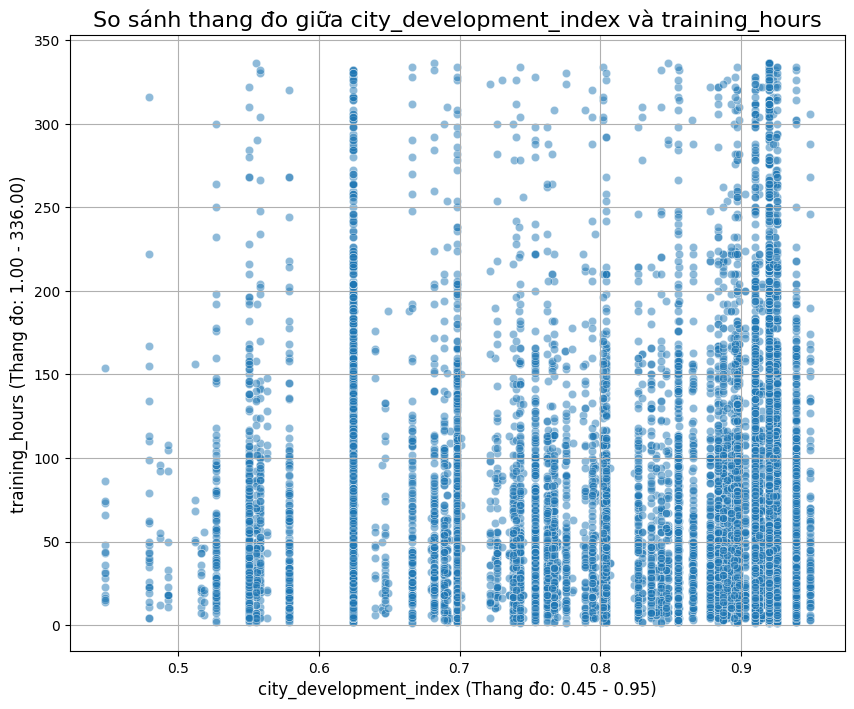

In [16]:
viz.plot_scaling_comparison(data, col1='city_development_index', col2='training_hours')


**Miền giá trị:**
- **`city_development_index`**: Nằm trong khoảng rất hẹp từ 0.45 đến 0.95 (chênh lệch ~0.5)
- **`training_hours`**: Trải rộng từ 1 đến 336 giờ (chênh lệch 336 đơn vị)
- Tỷ lệ chênh lệch giữa hai biến là khoảng **1:672** (336/0.5)

**Vấn đề scaling:**
- Sự khác biệt thang đo rất lớn giữa hai biến sẽ gây ra vấn đề nghiêm trọng cho các thuật toán nhạy cảm với khoảng cách (KNN, SVM, K-Means) hoặc sử dụng gradient descent (Logistic Regression, Neural Networks)
- Nếu không scaling, `training_hours` sẽ **chi phối hoàn toàn** quá trình học của mô hình do giá trị số lớn hơn rất nhiều
- `city_development_index` có thể bị "bỏ qua" mặc dù là yếu tố dự báo quan trọng (như đã thấy ở phân tích trước)

**Kết luận:** 
Đối với các mô hình nhạy cảm với khoảng cách thì bắt buộc phải áp dụng **chuẩn hóa** cho tất cả các biến số trước khi huấn luyện mô hình để đảm bảo mỗi đặc trưng đóng góp công bằng vào quá trình dự báo.

#### d. Chất lượng dữ liệu

In [17]:
print("Kiểm tra các giá trị không thể có:")
print(f"Số giờ đào tạo <= 0: {np.sum(data['training_hours'] <= 0)}")
print(f"Chỉ số phát triển thành phố < 0: {np.sum(data['city_development_index'] < 0)}")
print(f"Chỉ số phát triển thành phố > 1: {np.sum(data['city_development_index'] > 1)}")

Kiểm tra các giá trị không thể có:
Số giờ đào tạo <= 0: 0
Chỉ số phát triển thành phố < 0: 0
Chỉ số phát triển thành phố > 1: 0


**Nhận xét:**
Không có giá trị bất khả thi nào được tìm thấy trong các cột số. Dữ liệu có vẻ sạch về mặt này.

### 3.3. Phân tích các biến phân loại

In [18]:
categorical_cols = [name for name, dtype in data.dtype.fields.items() if not np.issubdtype(dtype[0], np.number)]
print(f"Các biến phân loại ({len(categorical_cols)}): {categorical_cols}")

Các biến phân loại (10): ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


#### a. Chất lượng dữ liệu

In [19]:
print("Kiểm tra tính nhất quán của các giá trị phân loại:")
for col in categorical_cols:
    unique_vals = np.unique(data[col])
    if col == 'city':
        # Chỉ in số giá trị vì cột city có quá nhiều giá trị
        print(f"- Cột '{col}' ({len(unique_vals)} giá trị khác)")
        continue
    print(f"- Cột '{col}' ({len(unique_vals)} giá trị khác nhau): {unique_vals}")

Kiểm tra tính nhất quán của các giá trị phân loại:
- Cột 'city' (123 giá trị khác)
- Cột 'gender' (4 giá trị khác nhau): ['' 'Female' 'Male' 'Other']
- Cột 'relevent_experience' (2 giá trị khác nhau): ['Has relevent experience' 'No relevent experience']
- Cột 'enrolled_university' (4 giá trị khác nhau): ['' 'Full time course' 'Part time course' 'no_enrollment']
- Cột 'education_level' (6 giá trị khác nhau): ['' 'Graduate' 'High School' 'Masters' 'Phd' 'Primary School']
- Cột 'major_discipline' (7 giá trị khác nhau): ['' 'Arts' 'Business Degree' 'Humanities' 'No Major' 'Other' 'STEM']
- Cột 'experience' (23 giá trị khác nhau): ['' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '3' '4'
 '5' '6' '7' '8' '9' '<1' '>20']
- Cột 'company_size' (9 giá trị khác nhau): ['' '10/49' '100-500' '1000-4999' '10000+' '50-99' '500-999' '5000-9999'
 '<10']
- Cột 'company_type' (7 giá trị khác nhau): ['' 'Early Stage Startup' 'Funded Startup' 'NGO' 'Other' 'Public Sector'
 'Pvt Ltd']
- Cộ

**Nhận xét:**

**Tính nhất quán của các biến phân loại:**
- **Không có lỗi chính tả hoặc biến thể:** Các giá trị trong từng cột đều nhất quán, không có trường hợp như 'Male'/'male' hoặc 'Graduate'/'graduate'
- **Giá trị rỗng (`''`)**: Xuất hiện ở 8 trong 10 biến phân loại, đại diện cho missing values đã được phân tích ở phần trước
- **Giá trị 'Other'**: Xuất hiện ở `gender`, `major_discipline`, và `company_type`, là các giá trị hợp lệ để nhóm các trường hợp không thuộc các category chính

**Các biến cần lưu ý:**
- **`experience`**: Có 23 giá trị khác nhau bao gồm cả số (1-20), khoảng ('<1', '>20'), và missing (''). Biến này có thể cần chuyển đổi sang dạng số hoặc ordinal encoding
- **`company_size`**: Có 9 giá trị với các khoảng không đồng nhất ('10/49', '50-99',..., '10000+'). Cần ordinal encoding hoặc nhóm lại
- **`last_new_job`**: Có 7 giá trị bao gồm số (1-4), khoảng ('>4'), và 'never'. Cần xử lý thứ tự tăng dần
- **`city`**: Có tới 123 giá trị khác nhau, chiếm gần 1% tổng số dòng. Không nên sử dụng one-hot encoding

**Kết luận:** Chất lượng dữ liệu của các biến phân loại khá tốt, không có lỗi nhập liệu rõ ràng.

#### b. Phân phối giá trị

##### city

Do cột `city` có **123 giá trị khác nhau** (high cardinality) nên sẽ chỉ hiển thỉ `top_n` thành phố.

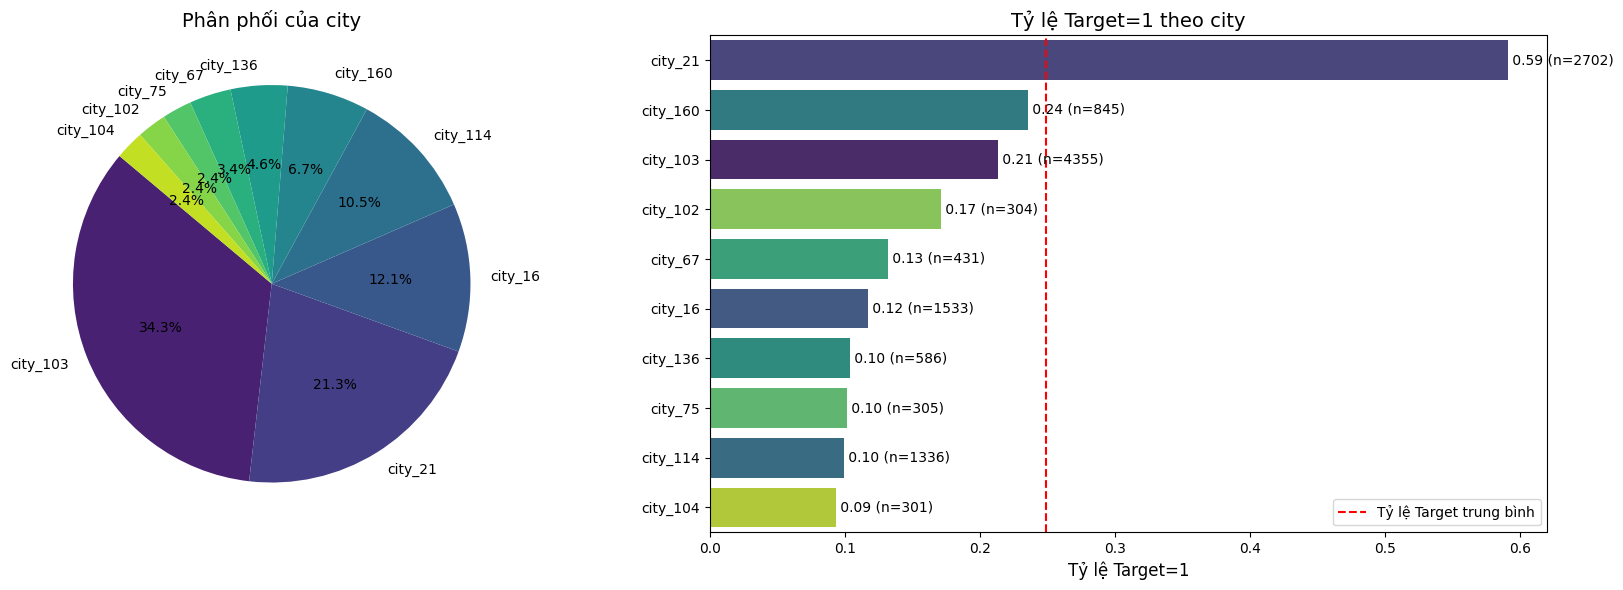

In [20]:
viz.plot_categorical_analysis(data, 'city', top_n=10)

**Nhận xét:**

**Phân phối city:**
- Biến `city` có **123 giá trị duy nhất** (high cardinality), biểu đồ chỉ hiển thị top 10 thành phố có nhiều ứng viên nhất
- **city_103** chiếm nhiều nhất với 4,355 ứng viên (~22.7%), gấp đôi thành phố xếp thứ 2
- Top 4 thành phố  chiếm **~52%** tổng số ứng viên
- Các thành phố còn lại (từ top 5 trở đi) có số lượng chênh lệch ít và giảm dần đều.

**Tỷ lệ target theo city:**
- **city_21** có tỷ lệ target=1 **cao nhất** (0.59), cao gấp hơn 2 lần mức trung bình (~0.25)
- **city_160**: gần mức trung bình
- Các thành phố còn lại đều thấp hơn mức trung bình đáng kể

**Insight:**
- Có sự **khác biệt lớn** về tỷ lệ tìm việc giữa các thành phố (0.09-0.59), cho thấy yếu tố địa lý quan trọng
- **city_21** có tỷ lệ cao bất thường $\rightarrow$ Có thể là thành phố nhỏ với ít cơ hội việc làm hoặc đang phát triển nhanh
- **city_103** (đông nhất) có tỷ lệ thấp $\rightarrow$ Có thể là thành phố lớn, phát triển với nhiều cơ hội việc làm, nhân viên ổn định hơn
- Biến này cần kết hợp với `city_development_index` để hiểu rõ hơn

##### gender

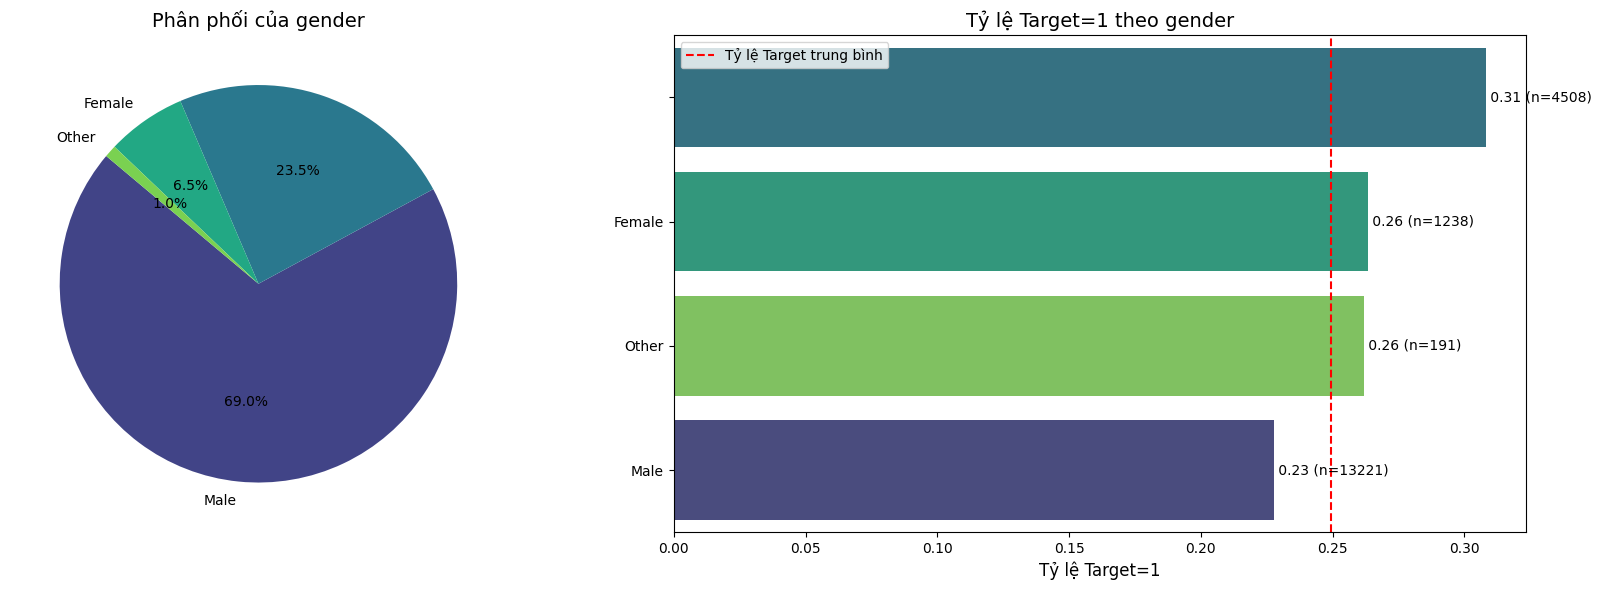

In [21]:
viz.plot_categorical_analysis(data, 'gender')

**Nhận xét:**

**Phân phối gender:**
- **Male** chiếm tuyệt đại đa số với 13,221 ứng viên (~69%), trong khi Female chỉ có 1,238 (~6.5%) và Other 191 (~1%)
- Có 4,508 giá trị missing (~23.5%), đã được phân tích ở phần trước
- Dữ liệu có sự **mất cân bằng nghiêm trọng** về giới tính, phản ánh thực tế ngành Data Science đang bị nam giới thống trị

**Tỷ lệ target theo gender:**
- **Missing values** có tỷ lệ target=1 cao nhất (0.31), cao hơn mức trung bình
- **Male** có tỷ lệ dưới mức trung bình, trong khi **Female và Other** có tỷ lệ tương đương nhau và gần với mức trung bình
- Sự khác biệt giữa các nhóm không quá lớn (0.23-0.31), cho thấy gender có **ảnh hưởng vừa phải** đến quyết định chuyển việc

**Insight:** Việc thiếu thông tin gender lại có tỷ lệ target=1 cao hơn, tương tự pattern đã thấy ở các biến liên quan đến công ty, củng cố giả thuyết về nhóm ứng viên "cố tình không tiết lộ thông tin cá nhân" có xu hướng chuyển việc cao hơn.

##### relevent_experience

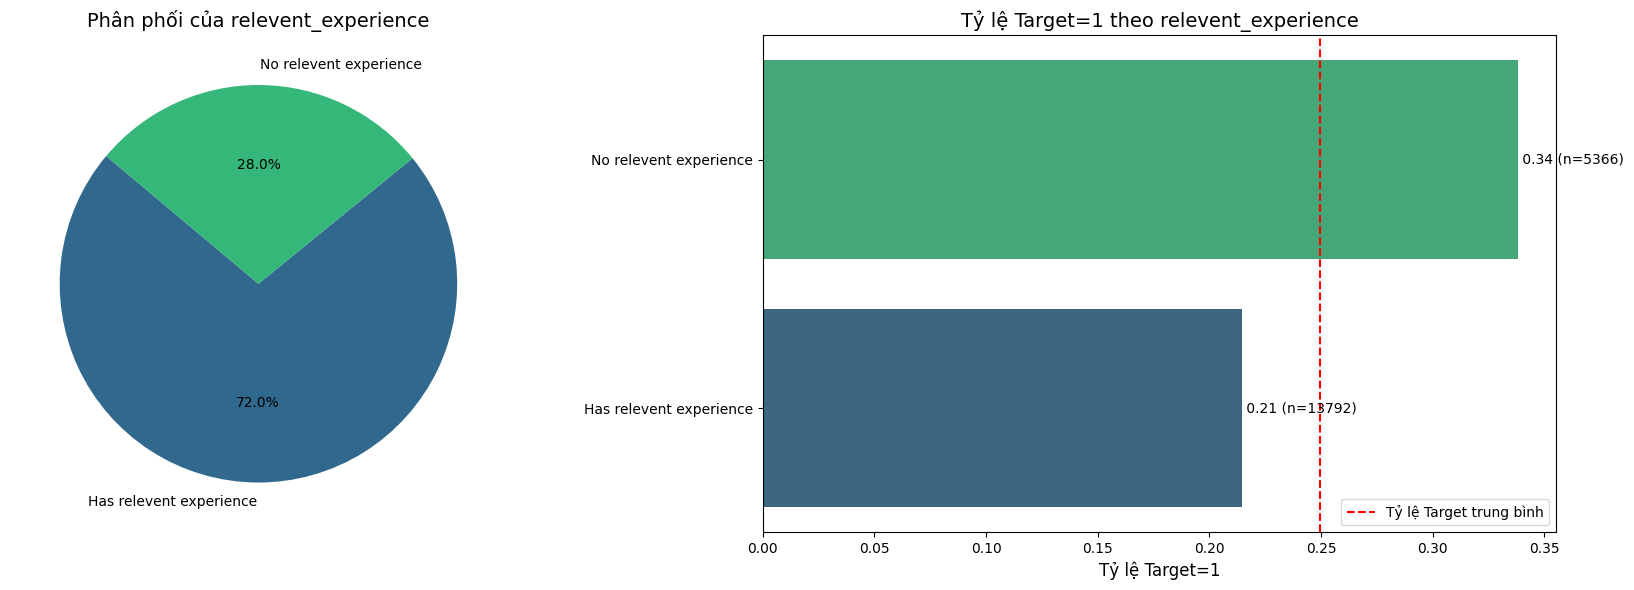

In [22]:
viz.plot_categorical_analysis(data, 'relevent_experience')

**Nhận xét:**

**Phân phối relevant_experience:**
- **Has relevant experience** chiếm đa số tuyệt đối với 13,792 ứng viên (~72%)
- **No relevant experience** chỉ có 5,366 ứng viên (~28%)
- Tỷ lệ 72:28 cho thấy hầu hết ứng viên tham gia khóa đào tạo đã có nền tảng kinh nghiệm liên quan đến Data Science

**Tỷ lệ target theo relevant_experience:**
- **No relevant experience** có tỷ lệ target=1 **cao hơn đáng kể** (0.34 vs 0.21), cao hơn mức trung bình (~0.25)
- Chênh lệch lớn (~62% cao hơn: 0.34/0.21) cho thấy đây là **yếu tố dự báo quan trọng**

**Insight:**
- Người **không có kinh nghiệm** liên quan có xu hướng tìm việc mới cao hơn, có thể vì:
  - Đang muốn chuyển đổi nghề nghiệp hoàn toàn → cần công việc mới để áp dụng kiến thức
  - Chưa có công việc ổn định trong lĩnh vực → đang tích cực tìm kiếm cơ hội
- Người **có kinh nghiệm** có thể chỉ muốn nâng cấp kỹ năng để phát triển ở vị trí hiện tại

**Kết luận:** `relevant_experience` là biến quan trọng, nhóm "No relevant experience" là target audience có khả năng rời công ty cao hơn sau đào tạo.

##### enrolled_university

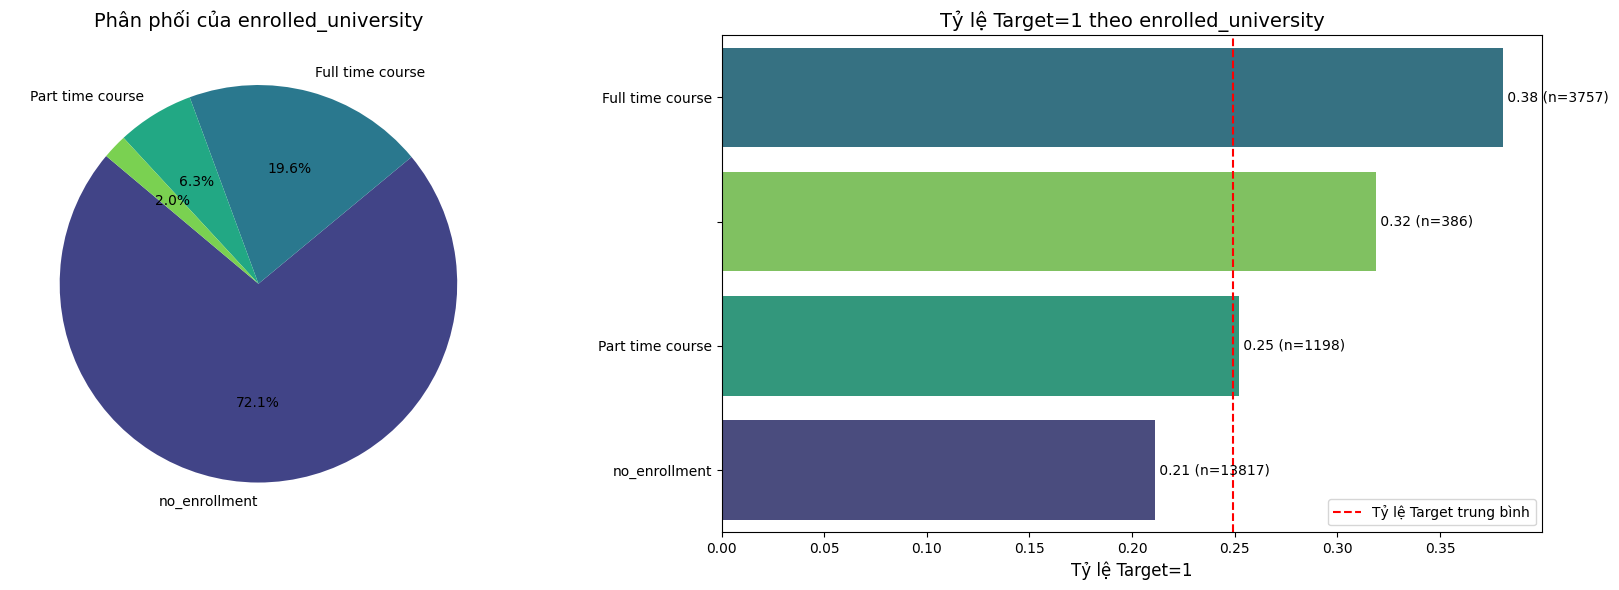

In [23]:
viz.plot_categorical_analysis(data, 'enrolled_university')

**Nhận xét:**

**Phân phối enrolled_university:**
- **no_enrollment** chiếm đa số với 13,817 ứng viên (~72%), cho thấy hầu hết ứng viên không đang theo học đại học.
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía `no_enrollment` cho thấy phần lớn là người không học đại học.

**Tỷ lệ target theo enrolled_university:**
- **Full time course** có tỷ lệ target=1 **cao nhất** (0.38), cao hơn đáng kể so với mức trung bình (~0.25)
- **Missing values** có tỷ lệ 0.32, cũng cao hơn trung bình
- **Part time course** có tỷ lệ bằng mức trung bình (0.25)
- **no_enrollment** có tỷ lệ **thấp nhất** (0.21), dưới mức trung bình

**Insight:**
- Sinh viên **Full time** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Sắp tốt nghiệp và đang tích cực tìm việc đầu tiên
  - Đang học để chuyển đổi nghề nghiệp hoàn toàn
  - Chưa có công việc ổn định nên cần tìm việc sau đào tạo
- Người **không học đại học** (no_enrollment) có xu hướng ở lại công ty cao hơn, có thể đã có công việc ổn định và chỉ muốn nâng cao kỹ năng

**Kết luận:** `enrolled_university` là yếu tố dự báo quan trọng. Nhóm "Full time course" có rủi ro rời công ty cao nhất sau đào tạo.

##### education_level

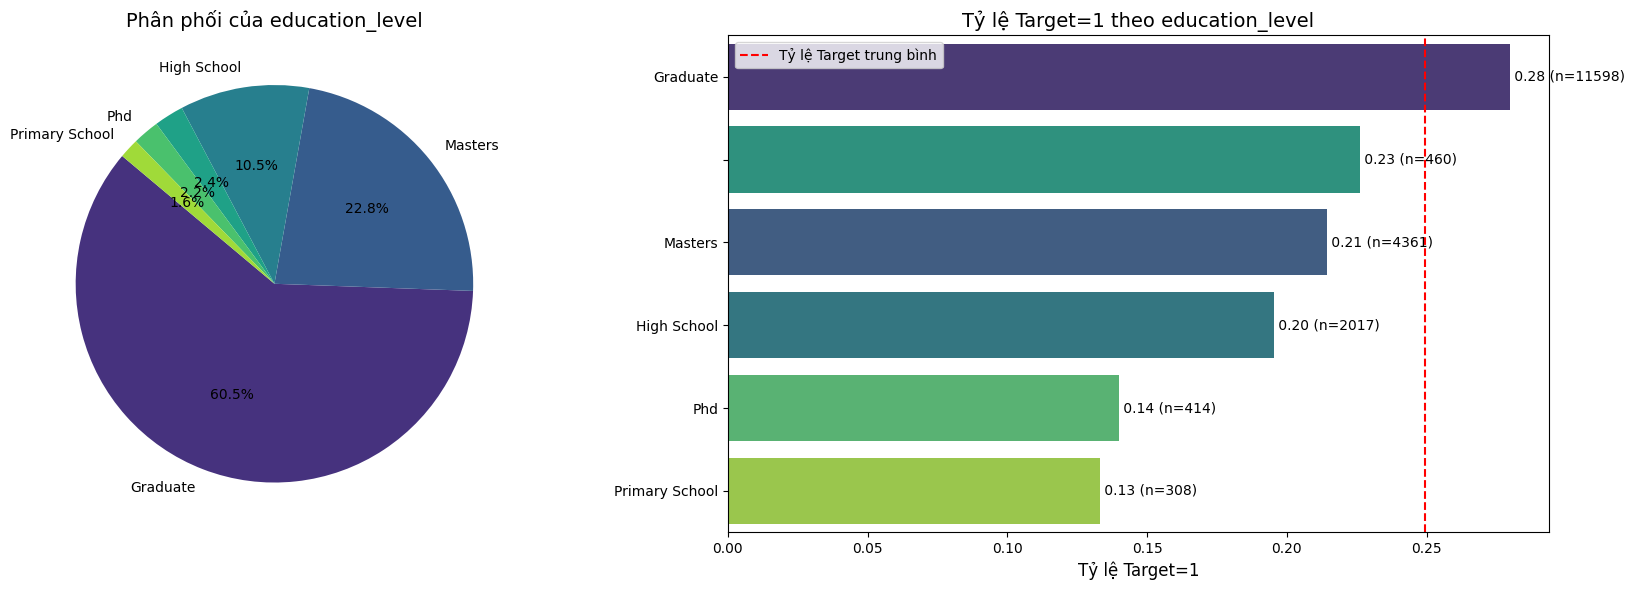

In [24]:
viz.plot_categorical_analysis(data, 'education_level')

**Nhận xét:**

**Phân phối education_level:**
- **Graduate** chiếm đa số áp đảo với 11,598 ứng viên (~60.5%), cho thấy hầu hết ứng viên có bằng đại học. 
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía **Graduate** cho thấy phần lớn là người đã tốt nghiệp đại học.

**Tỷ lệ target theo education_level:**

Có xu hướng **giảm dần** khi trình độ học vấn tăng:
  - **Graduate**: 0.28 (cao hơn mức trung bình ~0.25)
  - **Masters**: 0.21
  - **High School**: 0.20
  - **Phd**: 0.14 (thấp nhất, chỉ bằng một nửa Graduate)
  - **Primary School**: 0.13 (thấp nhất cùng Phd)

**Insight:**
- Người có bằng **Graduate** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Đây là trình độ phổ biến nhất trong ngành Data Science → nhiều cơ hội việc làm
  - Đủ năng lực để di chuyển nhưng chưa quá "cao cấp" như Masters/Phd
- Người có **Phd/Primary School** ít tìm việc hơn, có thể vì:
  - **Phd**: Đã có vị trí ổn định trong nghiên cứu/học thuật, khó tìm việc phù hợp
  - **Primary School**: Giới hạn về trình độ, ít cơ hội chuyển việc

**Kết luận:** `education_level` có mối quan hệ **phi tuyến** với target. Nhóm Graduate có rủi ro rời công ty cao nhất, trong khi Phd thấp nhất.

##### major_discipline

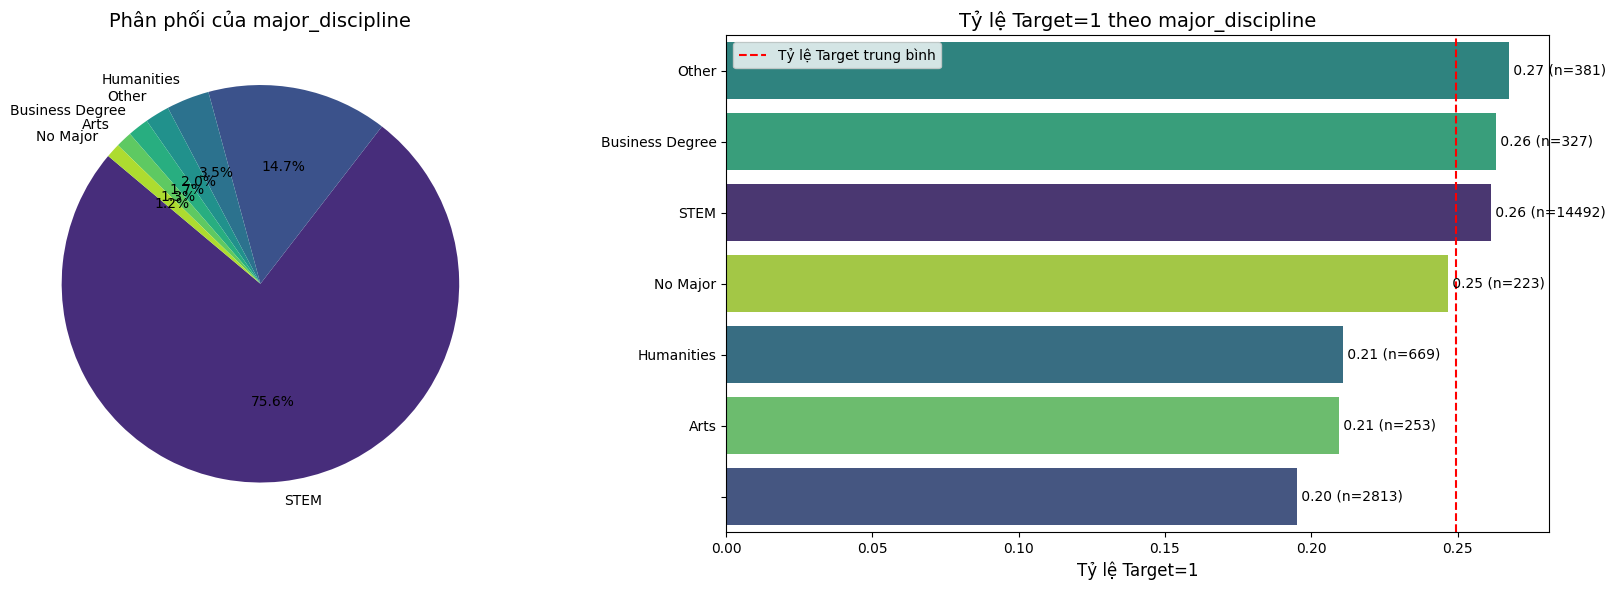

In [25]:
viz.plot_categorical_analysis(data, 'major_discipline')

**Nhận xét:**

**Phân phối major_discipline:**
- **STEM** chiếm đa số áp đảo với 14,492 ứng viên (~75.6%), phản ánh đúng bản chất của lĩnh vực Data Science
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía **STEM** cho thấy phần lớn các ứng viên học về lĩnh vực này.

**Tỷ lệ target theo major_discipline:**
- **Other**, **Business Degree** và **STEM** có tỷ lệ target=1 cao nhất (0.27 và 0.26), cao hơn mức trung bình
- Còn lại đều dưới mức trung bình

**Insight:**
- Người từ chuyên ngành **không phải STEM** (Other, Business) có xu hướng tìm việc cao hơn, có thể vì:
  - Đang chuyển đổi nghề nghiệp hoàn toàn → cần công việc mới để áp dụng
  - Chưa có nền tảng kỹ thuật vững → cần tìm việc entry-level
- Người **STEM** có tỷ lệ trung bình, có thể đã có việc ổn định trong lĩnh vực
- **Humanities/Arts** có tỷ lệ thấp bất ngờ, có thể do số lượng mẫu nhỏ hoặc họ tham gia khóa học vì sở thích hơn là chuyển nghề

**Kết luận:** `major_discipline` có ảnh hưởng vừa phải đến target. Nhóm chuyển đổi từ ngành khác (Other, Business) có xu hướng tìm việc cao hơn STEM.

##### experience

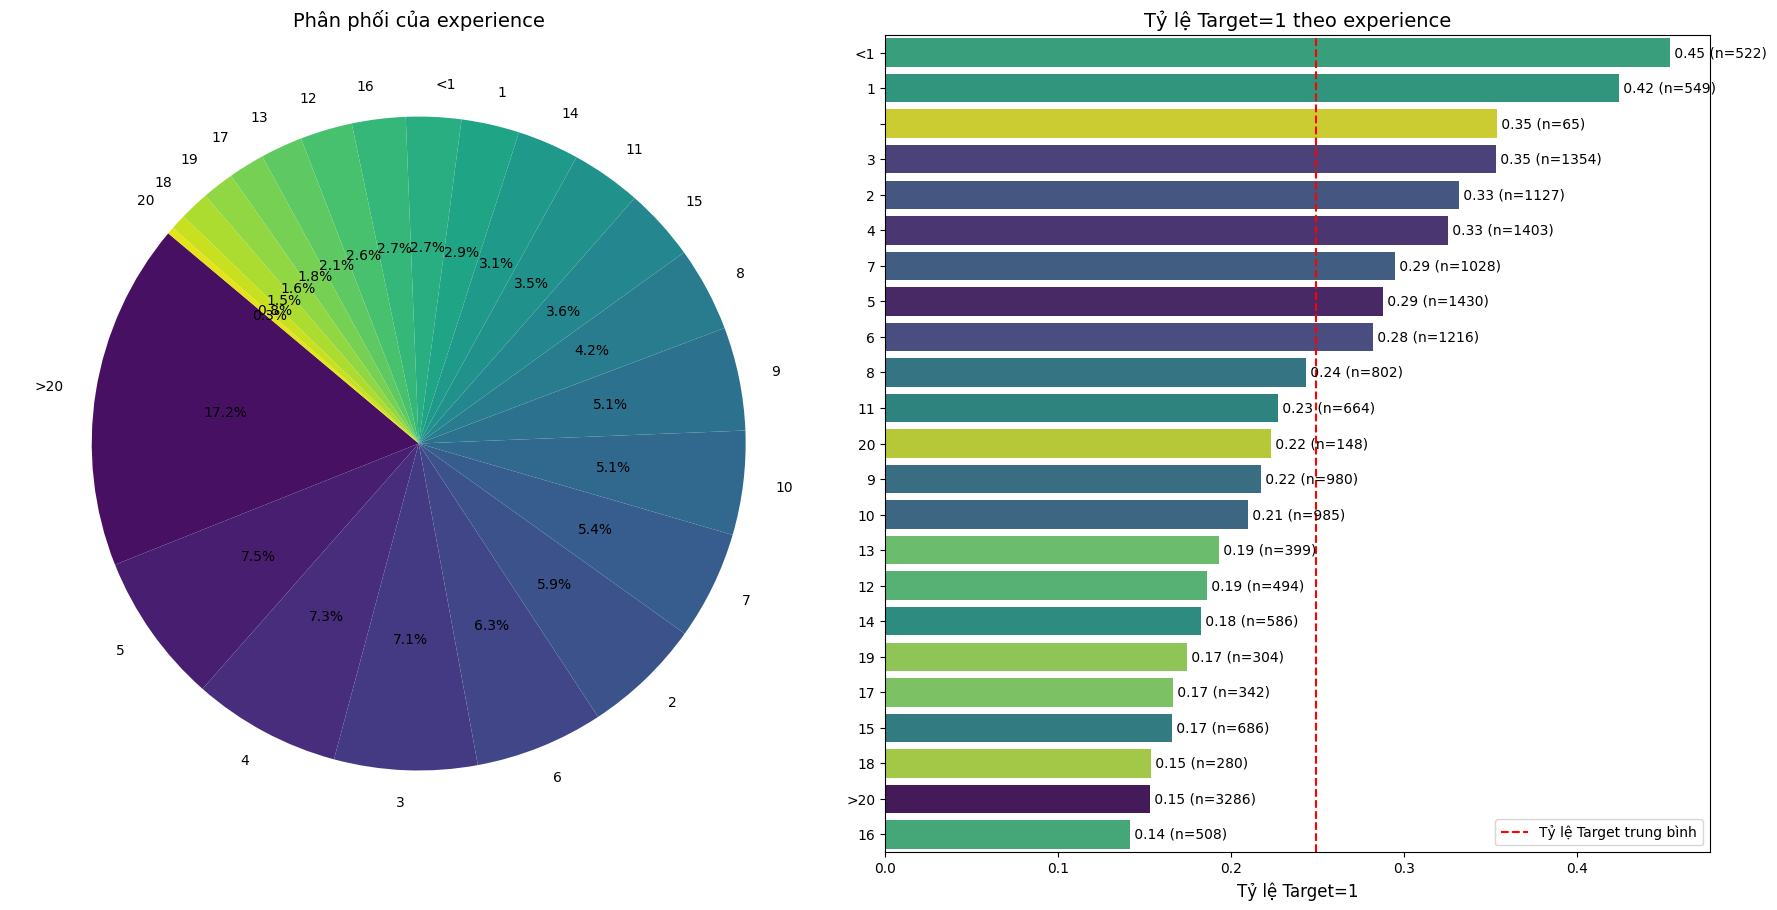

In [26]:
viz.plot_categorical_analysis(data, 'experience')

**Nhận xét:**

**Phân phối experience:**
- **>20 năm** chiếm nhiều nhất với 3,286 ứng viên (~17.1%)
- Phân phối tương đối **đồng đều** qua các khoảng kinh nghiệm từ 1-10 năm (mỗi nhóm ~800-1,400 người)
- **<1 năm**: 522 ứng viên (~2.7%)
- **Missing**: 65 ứng viên (~0.34%) - tỷ lệ thiếu rất thấp
- Có 23 giá trị duy nhất, cho thấy biến này rất chi tiết

**Tỷ lệ target theo experience:**

Có xu hướng **giảm dần** khi kinh nghiệm tăng:
  - **<1 năm và 1 năm**: Tỷ lệ cao nhất (0.45 và 0.42), cao hơn đáng kể so với mức trung bình (~0.25)
  - **2-7 năm**: Tỷ lệ từ 0.29-0.35, cao hơn hoặc gần mức trung bình
  - **8-15 năm**: Tỷ lệ giảm xuống 0.17-0.24, dưới mức trung bình
  - **>15 năm**: Tỷ lệ thấp nhất (0.14-0.17), chỉ bằng ~1/3 nhóm junior

**Insight:**
- **Junior (<3 năm kinh nghiệm)** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Đang trong giai đoạn khám phá nghề nghiệp, sẵn sàng thay đổi
  - Chưa gắn bó lâu dài với công ty hiện tại
  - Muốn tìm cơ hội tốt hơn sau khi nâng cấp kỹ năng
- **Senior (>15 năm)** có xu hướng ở lại thấp nhất, có thể vì:
  - Đã có vị trí và mức lương ổn định
  - Khó tìm việc phù hợp với level cao
  - Chi phí cơ hội khi chuyển việc lớn hơn

**Kết luận:** `experience` là yếu tố dự báo **rất quan trọng** với mối quan hệ **phi tuyến rõ rệt**. Nhóm junior (<3 năm) có rủi ro rời công ty cao gấp ~3 lần nhóm senior (>15 năm).

##### company_size

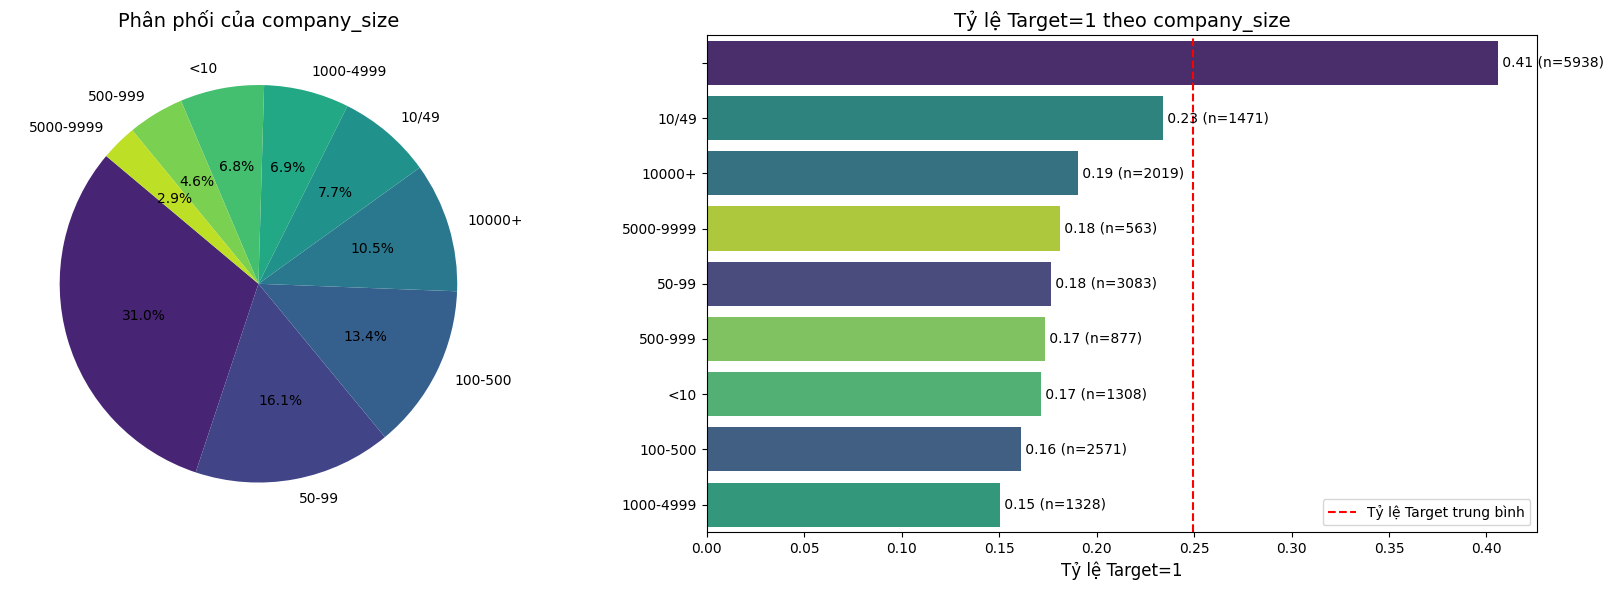

In [27]:
viz.plot_categorical_analysis(data, 'company_size')

**Nhận xét:**

**Phân phối company_size:**
- **Missing** chiếm đa số với 5,938 ứng viên (~31%), phản ánh tỷ lệ thiếu cao đã phân tích trước
- Các quy mô khác phân bố  không cách biệt quá mạnh 

**Tỷ lệ target theo company_size:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.41), cao hơn rất nhiều so với mức trung bình (~0.25) - củng cố phát hiện ở phân tích missing values
- Còn lại đều dưới mức trung bình

**Insight:**
- `Missing` $\rightarrow$ Tỷ lệ tìm việc cao nhất, có thể là:
  - Sinh viên/người thất nghiệp chưa có công ty
  - Freelancer/tự kinh doanh
  - Cố tình không tiết lộ vì đang muốn rời bỏ công ty hiện tại
- **Công ty nhỏ (10-49 người)** → Tỷ lệ cao thứ hai, có thể vì:
  - Lương thấp, phúc lợi kém hơn công ty lớn
  - Cơ hội phát triển hạn chế
  - Ổn định tài chính kém
- **Công ty lớn/trung bình** → Nhân viên ổn định hơn, ít muốn chuyển việc

**Kết luận:** `company_size` là yếu tố dự báo **rất quan trọng**. Missing value và công ty nhỏ có rủi ro rời bỏ cao gấp ~2-3 lần so với công ty lớn. Cần tạo missing indicator feature.

##### company_type

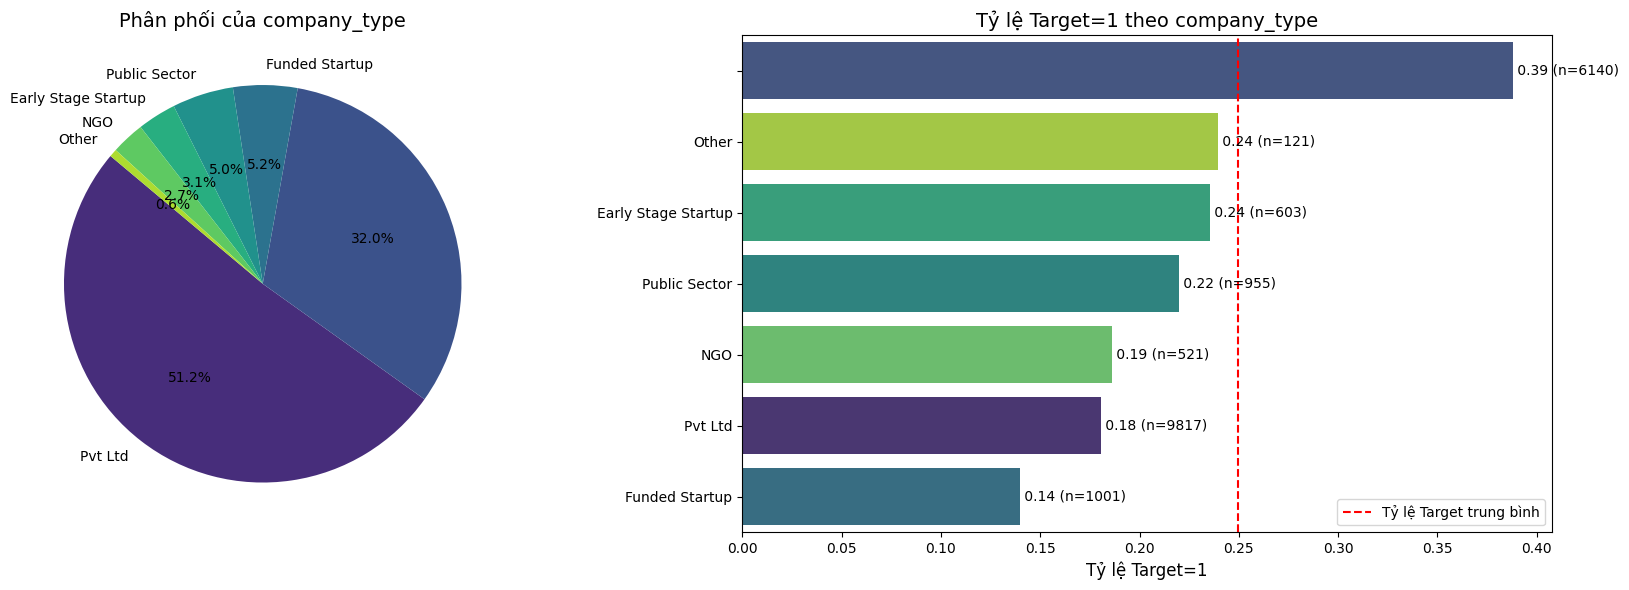

In [28]:
viz.plot_categorical_analysis(data, 'company_type')

**Nhận xét:**

**Phân phối company_type:**
- **Pvt Ltd** (công ty tư nhân) chiếm đa số với 9,817 ứng viên (~51.2%)
- **Missing** có 6,140 ứng viên (~32%), tỷ lệ thiếu cao như đã phân tích
- Còn lại có phân phối khá đều, cho thấy sự **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía `Pvt Ltd` và `Missing`

**Tỷ lệ target theo company_type:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.39), cao hơn rất nhiều so với mức trung bình (~0.25) - pattern tương tự company_size
- Còn lại đều dưới mức trung bình

**Insight:**
- **Missing** → Tỷ lệ tìm việc cao nhất, củng cố giả thuyết về nhóm không có công ty hoặc cố tình giấu thông tin
- **Early Stage Startup** → Tỷ lệ cao, có thể vì:
  - Công ty không ổn định, rủi ro phá sản
  - Lương thấp, áp lực cao
  - Muốn chuyển sang môi trường tốt hơn
- **Funded Startup** → Tỷ lệ thấp nhất, có thể vì:
  - Đã có funding nên ổn định hơn Early Stage
  - Lương và quyền chọn mua cổ phần hấp dẫn
  - Môi trường năng động, cơ hội thăng tiến
- **Pvt Ltd** (chiếm >50%) → Tỷ lệ thấp, phản ánh sự ổn định của các công ty tư nhân lớn

**Kết luận:** `company_type` là yếu tố dự báo **rất quan trọng**. Missing và Early Stage Startup có rủi ro cao gấp ~3 lần Funded Startup. Cần tạo missing indicator feature và xem xét group các startup lại.

##### last_new_job

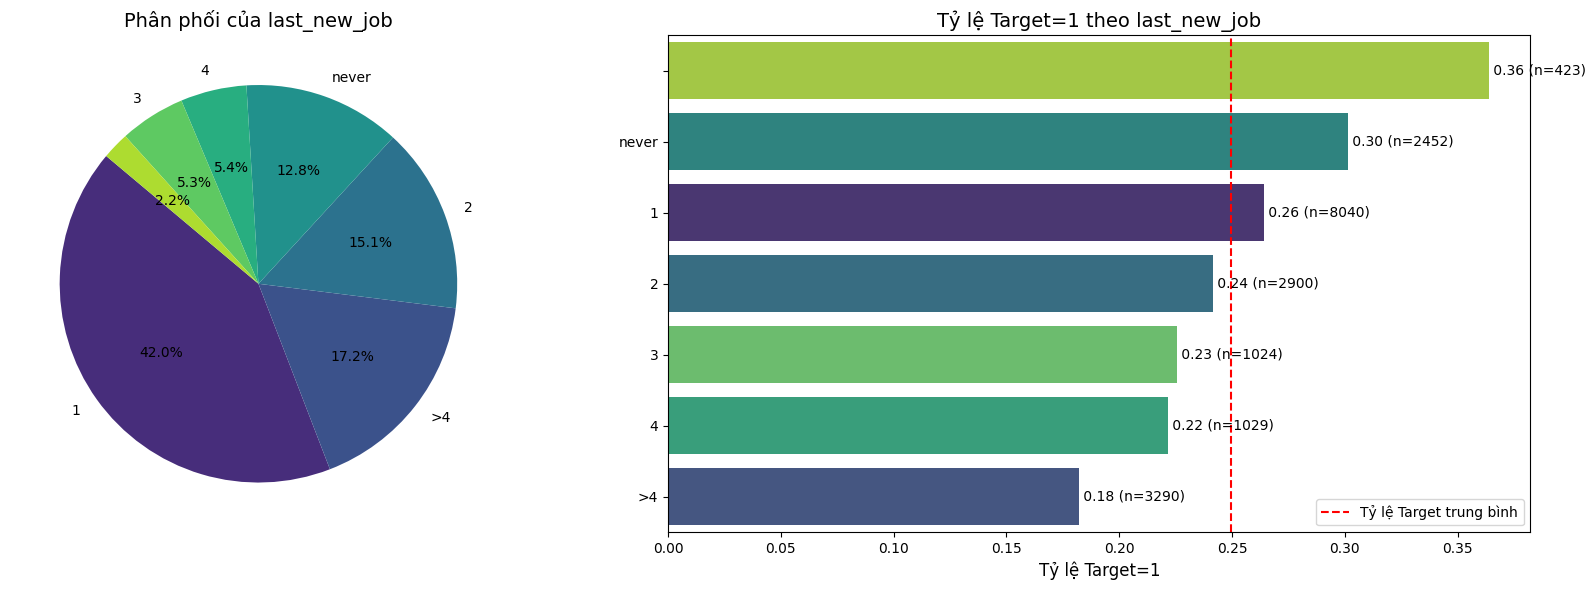

In [29]:
viz.plot_categorical_analysis(data, 'last_new_job')

**Nhận xét:**

**Phân phối last_new_job:**
- **1 năm** chiếm nhiều nhất với 8,040 ứng viên (~42%), cho thấy đa số ứng viên vừa mới chuyển công việc gần đây
- **>4 năm**, **2 năm** và **never** tương đối ngang nhau
- **4 năm**, **3 năm** và **Missing** thuộc nhóm thấp nhất

**Tỷ lệ target theo last_new_job:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.36), cao hơn đáng kể so với mức trung bình (~0.25)
- **never** và **1 năm**: đều cao hơn mức trung bình
- Còn lại đều dưới mức trung bình

**Insight:**
- **Missing và "never"** → Tỷ lệ tìm việc cao, có thể vì:
  - Missing: Sinh viên mới ra trường chưa có lịch sử việc làm
  - Never: Đang ở công việc đầu tiên, đã sẵn sàng thử thách mới sau đào tạo
- **1-2 năm** (vừa chuyển việc gần đây) → Tỷ lệ trung bình, có thể:
  - Vẫn đang thích nghi với môi trường mới
  - Nhưng cũng sẵn sàng xem xét cơ hội tốt hơn
- **>4 năm** (gắn bó lâu dài) → Tỷ lệ thấp nhất, phản ánh:
  - Đã ổn định và hài lòng với công việc hiện tại
  - Chi phí cơ hội khi chuyển việc cao
  - Có thể đã lên vị trí cao, khó tìm việc tương đương

**Kết luận:** `last_new_job` là yếu tố dự báo **quan trọng** với xu hướng rõ ràng: Người chưa từng chuyển việc hoặc vừa chuyển gần đây có xu hướng tìm việc cao gấp ~2 lần người gắn bó >4 năm. Biến này có tính ordinal cần xử lý đúng thứ tự.

### 3.4. Nhận xét tổng quan về các đặc trưng

Phân tích đơn biến đã cung cấp nhiều insight giá trị về các yếu tố ảnh hưởng đến xu hướng tìm việc của ứng viên:

1.  **Các yếu tố dự báo mạnh nhất:**
    *   **Kinh nghiệm (`experience`, `last_new_job`):** Đây là nhóm yếu tố có ảnh hưởng rõ rệt nhất. Ứng viên có ít kinh nghiệm (đặc biệt là dưới 5 năm) hoặc chưa bao giờ chuyển việc (`never`) có xu hướng tìm việc mới cao hơn đáng kể. Ngược lại, những người có kinh nghiệm lâu năm (>15 năm) hoặc đã gắn bó với công việc hiện tại trên 4 năm rất ổn định và ít có ý định thay đổi.
    *   **Thông tin công ty (`company_size`, `company_type`):** Việc thiếu thông tin về công ty là một tín hiệu dự báo cực kỳ mạnh. Ngoài ra, nhân viên làm việc tại các công ty nhỏ hoặc startup giai đoạn đầu (`Early Stage Startup`) cũng có tỷ lệ tìm việc cao hơn hẳn so với các công ty lớn, công ty tư nhân (`Pvt Ltd`) hoặc startup đã có vốn (`Funded Startup`).
    *   **Tình trạng học vấn (`enrolled_university`):** Sinh viên đang theo học toàn thời gian (`Full time course`) có tỷ lệ tìm việc cao nhất, cho thấy họ đang chuẩn bị cho sự nghiệp sau khi tốt nghiệp hoặc muốn chuyển ngành.

2.  **Các yếu tố dự báo có ảnh hưởng vừa phải:**
    *   **Chỉ số phát triển thành phố (`city_development_index`):** Ứng viên đến từ các thành phố có chỉ số phát triển thấp hơn có xu hướng tìm việc cao hơn. Đây là một yếu tố có giá trị dự báo.
    *   **Kinh nghiệm liên quan (`relevent_experience`):** Những người không có kinh nghiệm liên quan có xu hướng tìm việc cao hơn, có thể vì họ đang muốn chuyển sang một lĩnh vực mới.
    *   **Trình độ học vấn (`education_level`):** Mối quan hệ không hoàn toàn tuyến tính. Nhóm `Graduate` có tỷ lệ tìm việc cao nhất, trong khi nhóm `Masters` và đặc biệt là `Phd` lại có xu hướng ổn định hơn.
    *   **Giới tính (`gender`) và Chuyên ngành (`major_discipline`):** Có sự khác biệt nhưng không quá lớn. Đáng chú ý là việc thiếu thông tin giới tính lại tương quan với tỷ lệ tìm việc cao hơn.

3.  **Các yếu tố có ảnh hưởng yếu hoặc không rõ ràng:**
    *   **Số giờ đào tạo (`training_hours`):** Biến này không cho thấy sự khác biệt rõ rệt giữa hai nhóm `target`. Phân phối của nó gần như giống hệt nhau bất kể ứng viên có tìm việc hay không. Do đó, nó có thể không phải là một yếu tố dự báo mạnh khi đứng một mình.

**Kết luận chung:** Một ứng viên có khả năng cao đang tìm kiếm công việc mới là người có ít kinh nghiệm, đến từ một thành phố có chỉ số phát triển thấp, đang làm ở một công ty nhỏ/startup hoặc không tiết lộ thông tin công ty, và có thể đang là sinh viên toàn thời gian. Ngược lại, một ứng viên ổn định thường là người có nhiều năm kinh nghiệm, đến từ các thành phố phát triển và làm việc cho một công ty tư nhân lớn hoặc startup đã có vốn.

---

# 4. Phân Tích Đa Biến

### 4.1. Tương quan giữa các biến numerical

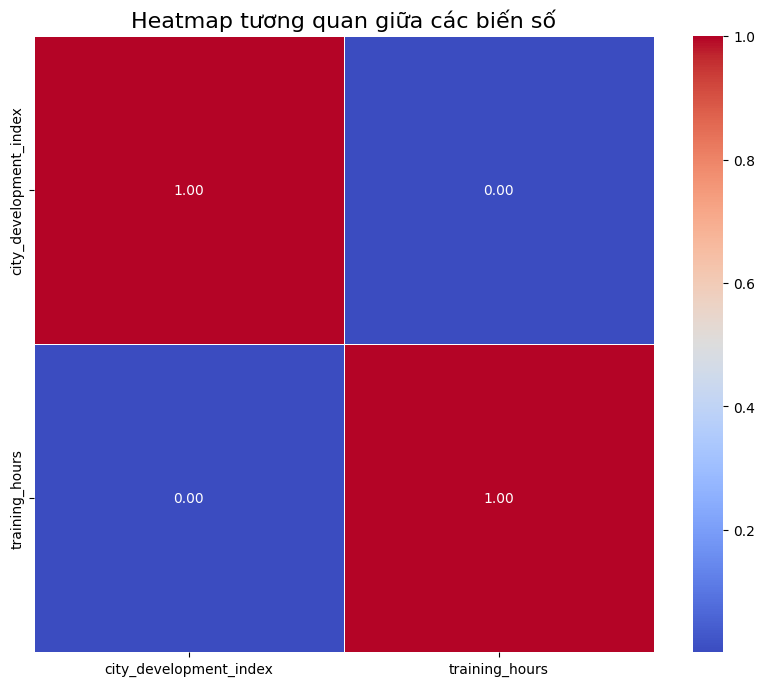

In [30]:
viz.plot_correlation_heatmap(data, numerical_cols)

Heatmap tương quan cho thấy không có mối tương quan tuyến tính nào giữa `city_development_index` và `training_hours`. Điều này cho thấy chúng cung cấp thông tin độc lập cho mô hình.

### 4.2. Đặt câu hỏi

### a. Sự dư thừa giữa **city** và **city_development_index**?

Một giả thuyết được đặt ra là cột `city` và `city_development_index` có thể chứa thông tin trùng lặp. Cụ thể, mỗi mã thành phố (`city`) có thể chỉ tương ứng với một giá trị chỉ số phát triển (`city_development_index`) duy nhất. Nếu điều này đúng, việc giữ lại cả hai cột trong mô hình có thể dẫn đến sự dư thừa và tăng số chiều không cần thiết.

Phân tích dưới đây sẽ kiểm tra giả thuyết này bằng cách nhóm dữ liệu theo từng thành phố và đếm số lượng `city_development_index` duy nhất cho mỗi thành phố.

In [31]:
# Phân tích mối quan hệ giữa city và city_development_index
city_index_summary = dp.analyze_city_and_index_relationship(data)

# In kết quả
print(f"Tổng số city duy nhất: {city_index_summary['num_unique_cities']}")
print(f"Tổng số index duy nhất: {city_index_summary['num_unique_indices']}")
print(f"Số city ánh xạ tới 1 chỉ số phát triển duy nhất: {city_index_summary['cities_mapping_to_one_index']}")
print(f"Số index được chia sẻ bởi nhiều city: {city_index_summary['indices_shared_by_multiple_cities']}")

Tổng số city duy nhất: 123
Tổng số index duy nhất: 93
Số city ánh xạ tới 1 chỉ số phát triển duy nhất: 123
Số index được chia sẻ bởi nhiều city: 12


Kết quả phân tích cho thấy **100%** trong số 123 `city` đều ánh xạ tới chính xác **một** giá trị `city_development_index`. Không có thành phố nào được tìm thấy có nhiều hơn một chỉ số phát triển.

Trong khi đó, `city_development_index` đối với `city` là mối quan hệ one-to-many. Một giá trị `city_development_index` có thể ánh xạ tới nhiều giá trị `city` 

**$\Rightarrow$ Giả thuyết là đúng.** Như vậy ta có thể loại bỏ một trong hai cột trước khi huấn luyện.

**Tại sao chọn `city_development_index` thay vì `city`?**

**1. `city` là tên gọi, trong khi `city_development_index` là giá trị**

Phân tích đã chứng minh mối quan hệ của `city` đối với `city_development_index` là **many-to-one**. **Nhiều** mã `city` khác nhau cùng trỏ về **một** giá trị `city_development_index` duy nhất. Ví dụ: `city_10`, `city_25`, và `city_80` có thể cùng có chỉ số là `0.920`.

Điều này có nghĩa là `city` chỉ là một cái tên hay "nhãn" đại diện cho một đặc tính đã được đo lường bằng `city_development_index`. Giá trị cốt lõi nằm ở con số chỉ số, không phải ở cái tên.

**2. Mô hình học từ số liệu, không phải từ tên gọi**

Mô hình máy học tìm kiếm các quy luật dựa trên số liệu.
- **Lợi ích khi dùng `city_development_index`:** Đây đã là một con số có ý nghĩa. Mô hình có thể học trực tiếp rằng "chỉ số càng thấp thì khả năng tìm việc càng cao".
- **Bất lợi khi dùng `city`:** Đây là một chuỗi ký tự. Mô hình không thể hiểu `city_103` là gì. Để sử dụng nó, ta phải thực hiện các bước mã hóa phức tạp để biến nó thành số, trong khi `city_development_index` đã là con số ta cần.

**Kết luận:**

Cột `city` là một đặc trưng dư thừa. Nó chỉ là một cái nhãn có quá nhiều giá trị (high cardinality) cho một thông tin đã được định lượng hóa bởi `city_development_index`. Do đó, **giữ lại `city_development_index` và loại bỏ `city`** sẽ giúp mô hình đơn giản, hiệu quả và tránh được các bước xử lý không cần thiết.

### b. Tương tác giữa **experience** và **city_development_index**

**Câu hỏi:** Liệu yếu tố **kinh nghiệm cao** có giúp giảm thiểu tỷ lệ muốn nghỉ việc ở những ứng viên đến từ các **thành phố kém phát triển** không?

**Mục đích:**
*   Ở phần đơn biến, ta thấy: CDI thấp $\rightarrow$ Tỷ lệ nghỉ cao. Thâm niên cao $\rightarrow$ Tỷ lệ nghỉ thấp.
*   Ta cần biết khi hai yếu tố này đối đầu nhau thì cái nào thắng thế? Liệu một người có kinh nghiệm >20 năm sống ở thành phố kém phát triển có muốn rời đi (để tìm cơ hội tốt hơn ở thành phố lớn) hay họ chọn ở lại (vì đã ổn định hay còn gọi là "cá lớn trong ao nhỏ")?

Sử dụng biểu đồ nhiệt để quan sát tỷ lệ `target=1` trên lưới kết hợp giữa thâm niên và các nhóm chỉ số phát triển thành phố.

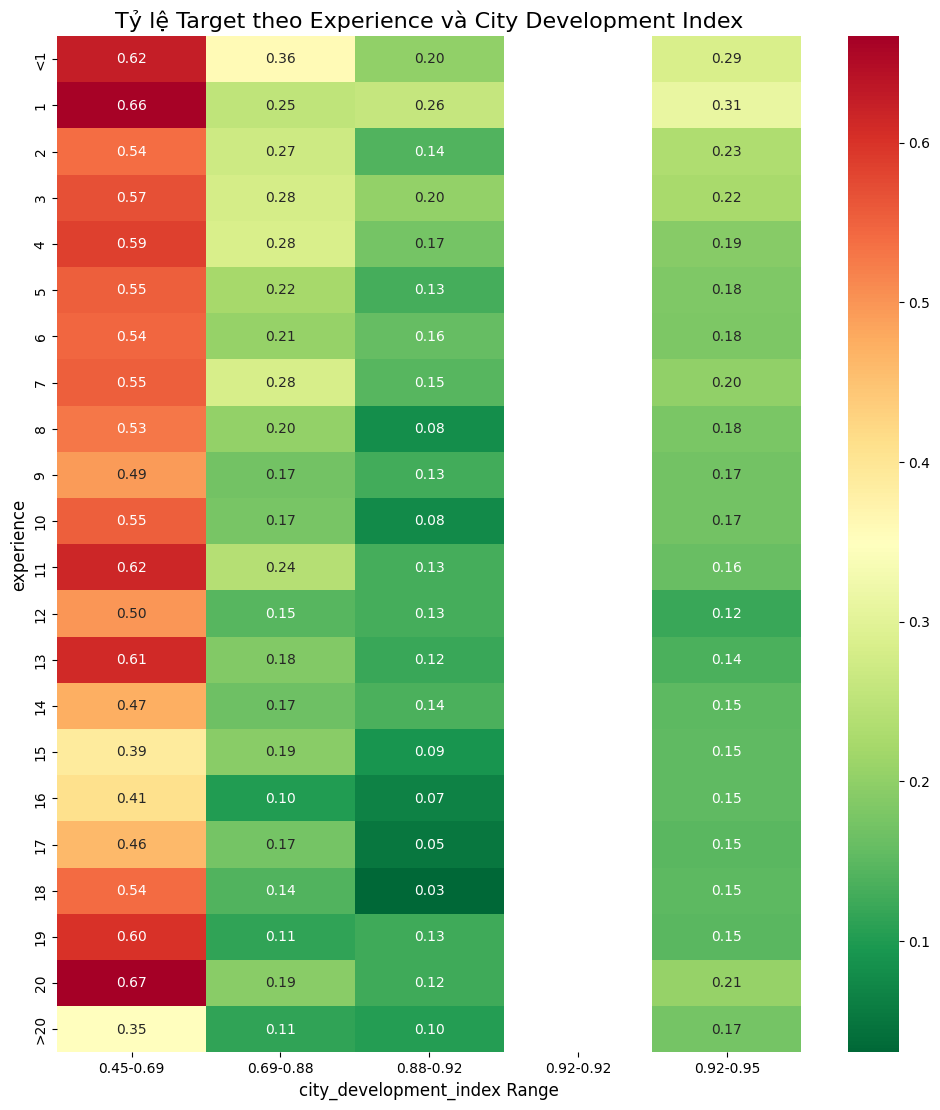

In [32]:
viz.plot_binned_heatmap(data, 'experience', 'city_development_index', bins=5, title='Tỷ lệ Target theo Experience và City Development Index')

**Nhận xét:**
*   **CDI áp đảo experience:** Biểu đồ phân hóa màu sắc rõ rệt theo chiều ngang. Ở các thành phố kém phát triển (cột trái), tỷ lệ muốn nghỉ việc luôn ở mức báo động (>50%) bất kể ứng viên làm lâu năm hay mới vào nghề.
*   **Nghịch lý tại vùng kém phát triển:** Trong khi ở thành phố lớn, người càng có kinh nghiệm càng ít nghỉ việc (theo đúng quy luật), thì ở thành phố kém phát triển, nhóm nhân sự cốt cán (10-20 năm kinh nghiệm) lại có tỷ lệ muốn ra đi cao nhất (lên tới 0.67).

**Insight:**
*   **Môi trường quan trọng hơn thâm niên:** Yếu tố địa lý là biến số dự báo mạnh hơn kinh nghiệm cá nhân. Một chuyên gia (Senior) ở thành phố nhỏ có nguy cơ rời bỏ công ty cao hơn nhiều so với một nhân viên mới (Junior) ở thành phố lớn.
*   Nhóm nhân sự cấp cao tại các thành phố kém phát triển dường như đã chạm ngưỡng phát triển tối đa tại địa phương ("cá lớn ao nhỏ"), thúc đẩy họ tìm kiếm cơ hội mới ở các đô thị lớn hơn thay vì an phận.

Như vậy câu trả lời là **không.** Tại các thành phố kém phát triển, thâm niên cao không những không giúp giảm tỷ lệ nghỉ việc mà còn là nhóm có xu hướng muốn rời đi mạnh mẽ nhất. Thâm niên chỉ đóng vai trò là yếu tố giữ chân nhân sự hiệu quả khi họ đang làm việc tại các thành phố phát triển.

### c. Mối quan hệ giữa trình độ học vấn (**education_level**) và loại hình công ty (**company_type**)

**Câu hỏi:** Những ứng viên có bằng cấp cao (**Masters/PhD**) thường có xu hướng tìm việc mới khi làm việc tại môi trường nào: **Startups** hay **Công ty tư nhân lớn (Pvt Ltd)**?

**Mục đích:**
*   Ta thấy `PhD` thường ít nhảy việc, và `Startup` thì có tỷ lệ nhân viên nghỉ việc cao.
*   Tuy nhiên, Startups công nghệ thường cần nhân sự chất lượng cao (PhD/Masters). Cần kiểm tra xem liệu nhóm tri thức cao này có bị vỡ mộng khi làm ở Startup không, hay họ hài lòng hơn khi làm ở các công ty lớn (Pvt Ltd).

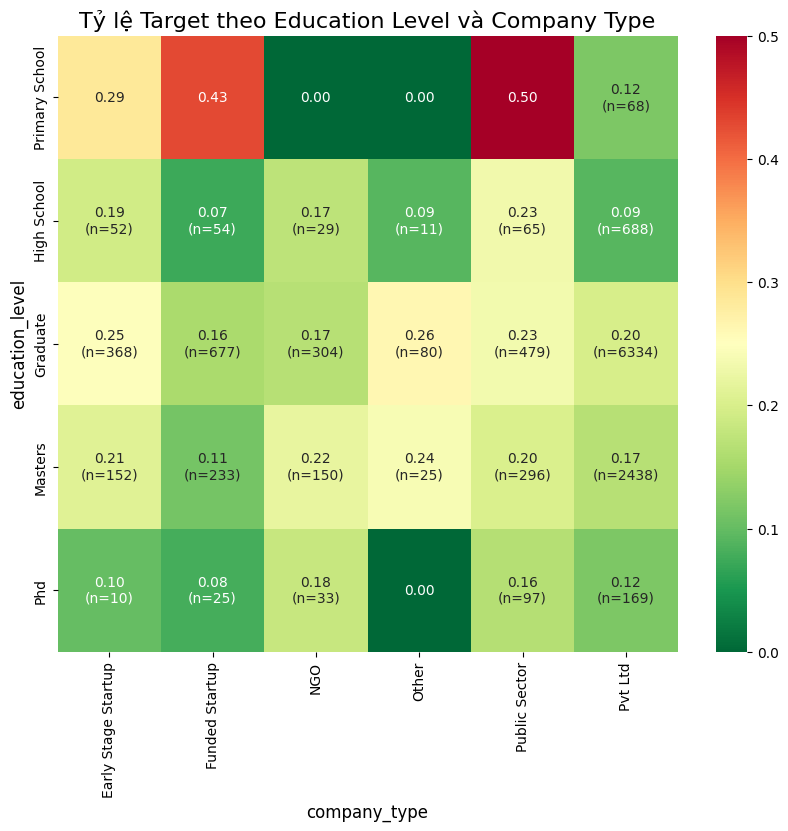

In [33]:
viz.plot_heatmap_target_rate(data, 'education_level', 'company_type', title='Tỷ lệ Target theo Education Level và Company Type')

**Nhận xét:**
*   Đối với nhóm học vấn cao (Masters, PhD), Funded Startup là nơi có tỷ lệ muốn nghỉ việc **thấp nhất** (chỉ 0.08 - 0.11), thấp hơn đáng kể so với công ty tư nhân lớn (Pvt Ltd).
*   **Sự phân hóa của Startup:**
    *   **Với Masters:** Có sự chênh lệch lớn giữa hai loại hình startup. Tại *Early Stage* (giai đoạn đầu), tỷ lệ muốn nghỉ là 0.21 (màu vàng), nhưng sang *Funded* (đã có vốn) giảm một nửa xuống còn 0.11 (màu xanh đậm).
    *   **Với PhD:** Tỷ lệ nghỉ việc cực thấp ở hầu hết các loại hình công ty (toàn dải màu xanh), ngoại trừ NGO (0.18) và mẫu nhỏ ở Early Stage.
*   **Pvt Ltd - Lựa chọn trung tính:** Tại các công ty tư nhân lớn, tỷ lệ nghỉ việc của nhóm Masters (0.17) và PhD (0.12) nằm ở mức trung bình, ổn định nhưng không hấp dẫn bằng Funded Startup.

**Insight:**
*   **Funded Startup là sweet spot:** Nhóm nhân sự trình độ cao dường như tìm thấy sự cân bằng lý tưởng tại các Funded Startup: vừa có thách thức công nghệ/sự đổi mới (đặc trưng của Startup) vừa có sự đảm bảo về tài chính (đặc trưng của Funded). Đây là môi trường giữ chân họ tốt hơn cả các tập đoàn lớn.
*   **Rủi ro ở Early Stage:** Nhóm Thạc sĩ (Masters) làm việc tại startup giai đoạn đầu có xu hướng rời đi cao hơn. Có thể do sự bất ổn về tài chính hoặc quy trình làm việc chưa chuyên nghiệp khiến nhóm nhân sự cấp cao này cảm thấy rủi ro.
*   **PhD - Nhóm ít biến động:** Những người có bằng Tiến sĩ có độ trung thành rất cao bất kể loại hình công ty (ngoại trừ NGO), có thể do tính chất công việc chuyên sâu khiến họ ít có nhiều lựa chọn thay thế ngang hàng trên thị trường.

**Trả lời:** **Phụ thuộc vào giai đoạn của Startup.**
*   Nhóm bằng cấp cao **gắn bó nhất với Funded Startup** (tỷ lệ tìm việc thấp hơn cả Pvt Ltd).
*   Tuy nhiên, họ có xu hướng **rời bỏ Early Stage Startup** (đặc biệt là nhóm Masters) cao hơn so với Pvt Ltd.
*   Tóm lại: **Funded Startup > Pvt Ltd > Early Stage Startup** về khả năng giữ chân nhân tài trình độ cao.

### d. Sự khác biệt về hành vi đào tạo (**training_hours**) giữa các nhóm tìm việc

**Câu hỏi:** Có sự khác biệt nào về số giờ đào tạo (**Training Hours**) giữa những người muốn chuyển việc (**Target=1**) nhưng có lịch sử nhảy việc khác nhau (**Last New Job**) không?

**Mục đích:**
*   Ở phân tích đơn biến, `training_hours` không cho thấy sự khác biệt rõ rệt giữa Target 0 và 1.
*   Tuy nhiên, có thể nhóm "nhảy việc liên tục" (`last_new_job`=1) sẽ training theo kiểu khác (ngắn hạn/cấp tốc) so với nhóm "người làm lâu năm muốn đổi gió" (`last_new_job`>4).

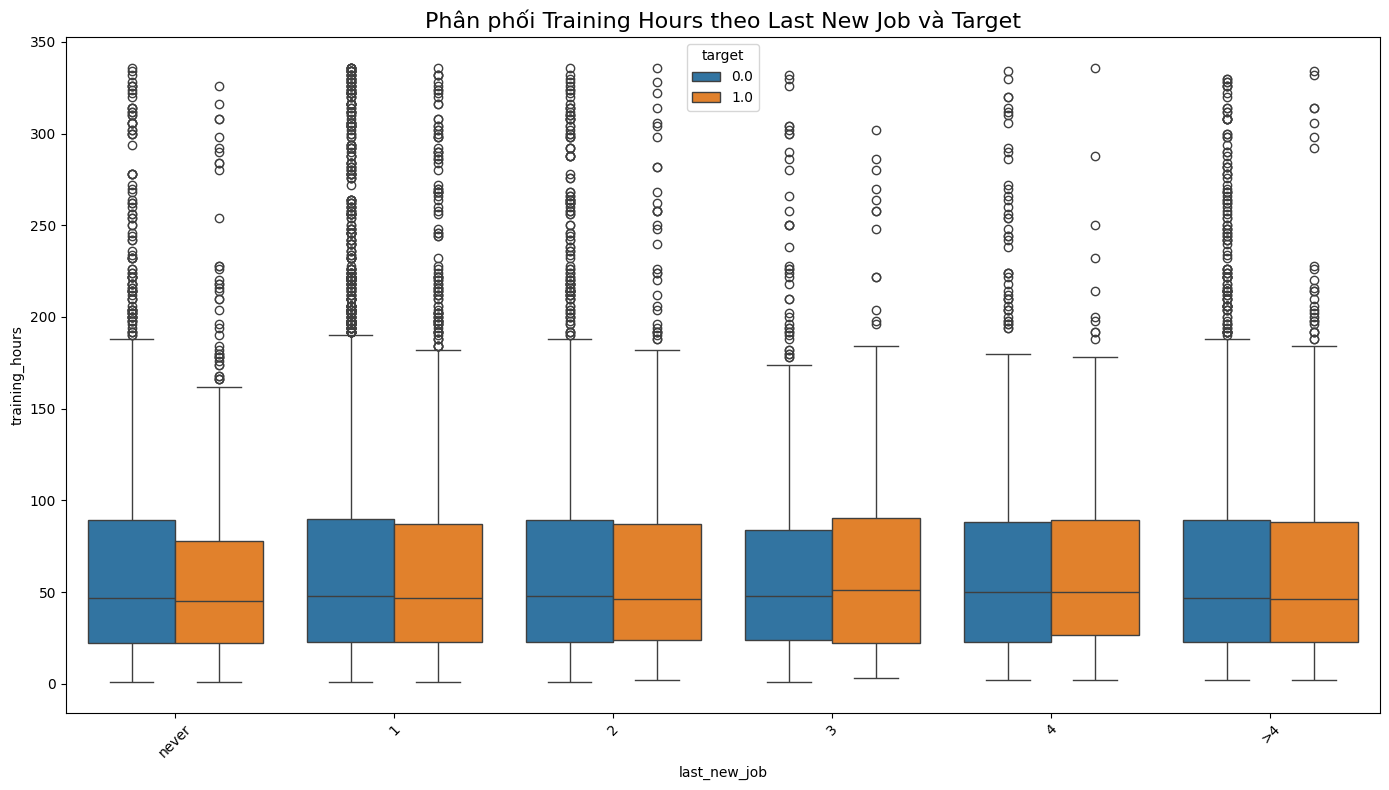

In [34]:
viz.plot_multivariate_boxplot(data, 'last_new_job', 'training_hours', 'target', title='Phân phối Training Hours theo Last New Job và Target')

**Nhận xét:**
*   **Sự tương đồng tuyệt đối:** Ở tất cả các nhóm lịch sử công việc (từ `never` đến `>4`), phân phối số giờ đào tạo của nhóm muốn đổi việc (cam) và nhóm ở lại (xanh) gần như **trùng khít nhau**.
*   **Trung vị và độ phân tán không đổi:** Đường trung vị của cả hai nhóm đều dao động quanh mức ~50 giờ. Độ trải giữa (IQR) cũng tương đương nhau.
*   **Outliers xuất hiện đều:** Các giá trị ngoại lai (những người học cực nhiều, >150 giờ) xuất hiện dày đặc ở **cả hai nhóm** target, không thiên về bên nào.

**Insight:**
*   **Số giờ học không định đoạt hành vi rời đi:** Dù ứng viên là người hay nhảy việc (1 năm) hay người trung thành (>4 năm), việc họ tham gia đào tạo nhiều hay ít **không** phải là tín hiệu báo trước việc họ sắp nghỉ việc.
*   **Bác bỏ giả thuyết "học để nhảy việc":** Dữ liệu phủ định suy đoán rằng "người muốn nghỉ việc sẽ tranh thủ học nhiều hơn để làm đẹp CV". Thực tế, động lực học tập của người muốn đi và người muốn ở lại là như nhau.
*   **Biến số yếu:** `training_hours` thể hiện mình là một đặc trưng rất yếu, không có khả năng phân loại tốt ngay cả khi đã kết hợp với các biến khác.

**Trả lời:** **KHÔNG**

Không có bất kỳ sự khác biệt đáng kể nào. Hành vi đào tạo là đồng nhất giữa các nhóm. Điều này khẳng định `training_hours` là một biến độc lập, ít tương tác với lịch sử công việc và không mang nhiều giá trị dự báo cho biến mục tiêu `target`. Tuy nhiên, mô hình Random Forest có thể xử lý tốt việc này.

### e. **experience** và **company_size**

**Câu hỏi:** Tỷ lệ muốn nghỉ việc tại các **Công ty nhỏ (<50 nhân viên)** có sự phân hóa như thế nào giữa nhóm **Junior (<2 năm)** và **Senior (>10 năm)**?

**Mục đích:**
*   Ta biết công ty nhỏ có tỷ lệ nghỉ việc cao. Nhưng ai là người bỏ đi?
*   Có phải chỉ là Junior coi công ty nhỏ là bàn đạp để lấy kinh nghiệm rồi nhảy sang công ty lớn? Hay cả Senior cũng bỏ đi vì công ty nhỏ không đủ nguồn lực đãi ngộ?

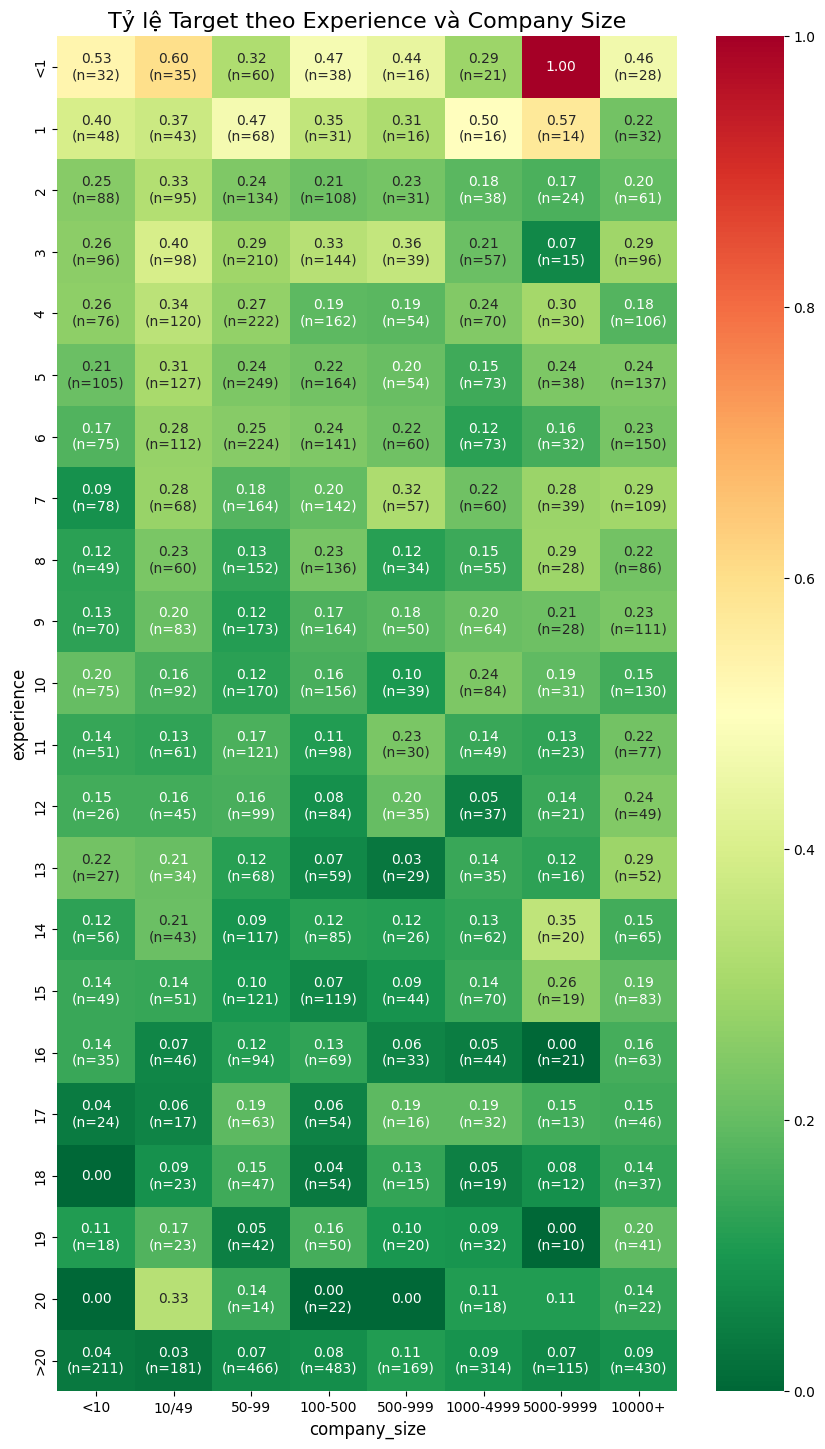

In [35]:
viz.plot_heatmap_target_rate(data, 'experience', 'company_size', title='Tỷ lệ Target theo Experience và Company Size')

**Nhận xét:**
*   **Sự phân cực cực đại tại công ty nhỏ:** Các công ty quy mô nhỏ (`<10` và `10/49`) chứng kiến sự đối lập gay gắt nhất.
    *   Nhóm **Junior (< 1 năm)** có tỷ lệ nghỉ việc cao khủng khiếp, chạm mốc **0.60** (màu cam đậm).
    *   Ngược lại, nhóm **Senior (> 20 năm)** tại đây lại có tỷ lệ nghỉ việc thấp kỷ lục, chỉ **0.03 - 0.04** (màu xanh đậm nhất biểu đồ).
*   Nhìn tổng thể theo chiều dọc, bất kể quy mô công ty lớn hay nhỏ, khi thâm niên tăng lên, màu sắc đều chuyển dần từ vàng/cam sang xanh. Thâm niên càng cao, nhân sự càng ổn định.

**Insight:**
*   **Tư duy "bàn đạp" của Junior:** Với nhân sự trẻ, công ty nhỏ thường chỉ là nơi bắt đầu để tích lũy kinh nghiệm (hoặc do chưa đủ sức vào công ty lớn). Sau thời gian ngắn, họ có xu hướng rời đi để tìm kiếm mức lương tốt hơn hoặc thương hiệu lớn hơn.
*   **"Cá lớn ao nhỏ" đối với Senior:** Những người có thâm niên cao (>20 năm) ở lại công ty nhỏ thường nắm giữ các vị trí chủ chốt, có quyền lực lớn, sự tự chủ cao hoặc thậm chí là cổ đông/người cùng sáng lập. Do đó, họ cực kỳ gắn bó và ít có động lực rời đi hơn cả khi làm ở tập đoàn lớn.
*   **Quy luật đảo chiều so với địa lý:** Nếu ở biểu đồ *City Development Index*, yếu tố môi trường áp đảo kinh nghiệm, thì ở đây **Kinh nghiệm áp đảo quy mô công ty**. Thâm niên đủ lớn có thể triệt tiêu rủi ro nghỉ việc ngay cả ở những công ty nhỏ thiếu ổn định nhất.

**Trả lời:** **Phân hóa đối lập hoàn toàn.**
*   Nhóm **Junior** chỉ coi công ty nhỏ là bàn đạp tạm thời, tỷ lệ muốn nghỉ việc cao nhất hệ thống (lên tới 60%).
*   Nhóm **Senior** coi công ty nhỏ là "nhà", tỷ lệ muốn nghỉ việc thấp nhất hệ thống (chỉ khoảng 3-4%).
*   Biến `company_size` không đơn thuần là "càng to càng tốt", mà nó hoạt động như một bộ lọc: thanh lọc người mới và giữ chân người cũ.

---

# 5. So sánh phân phối giữa tập `train` và `test`

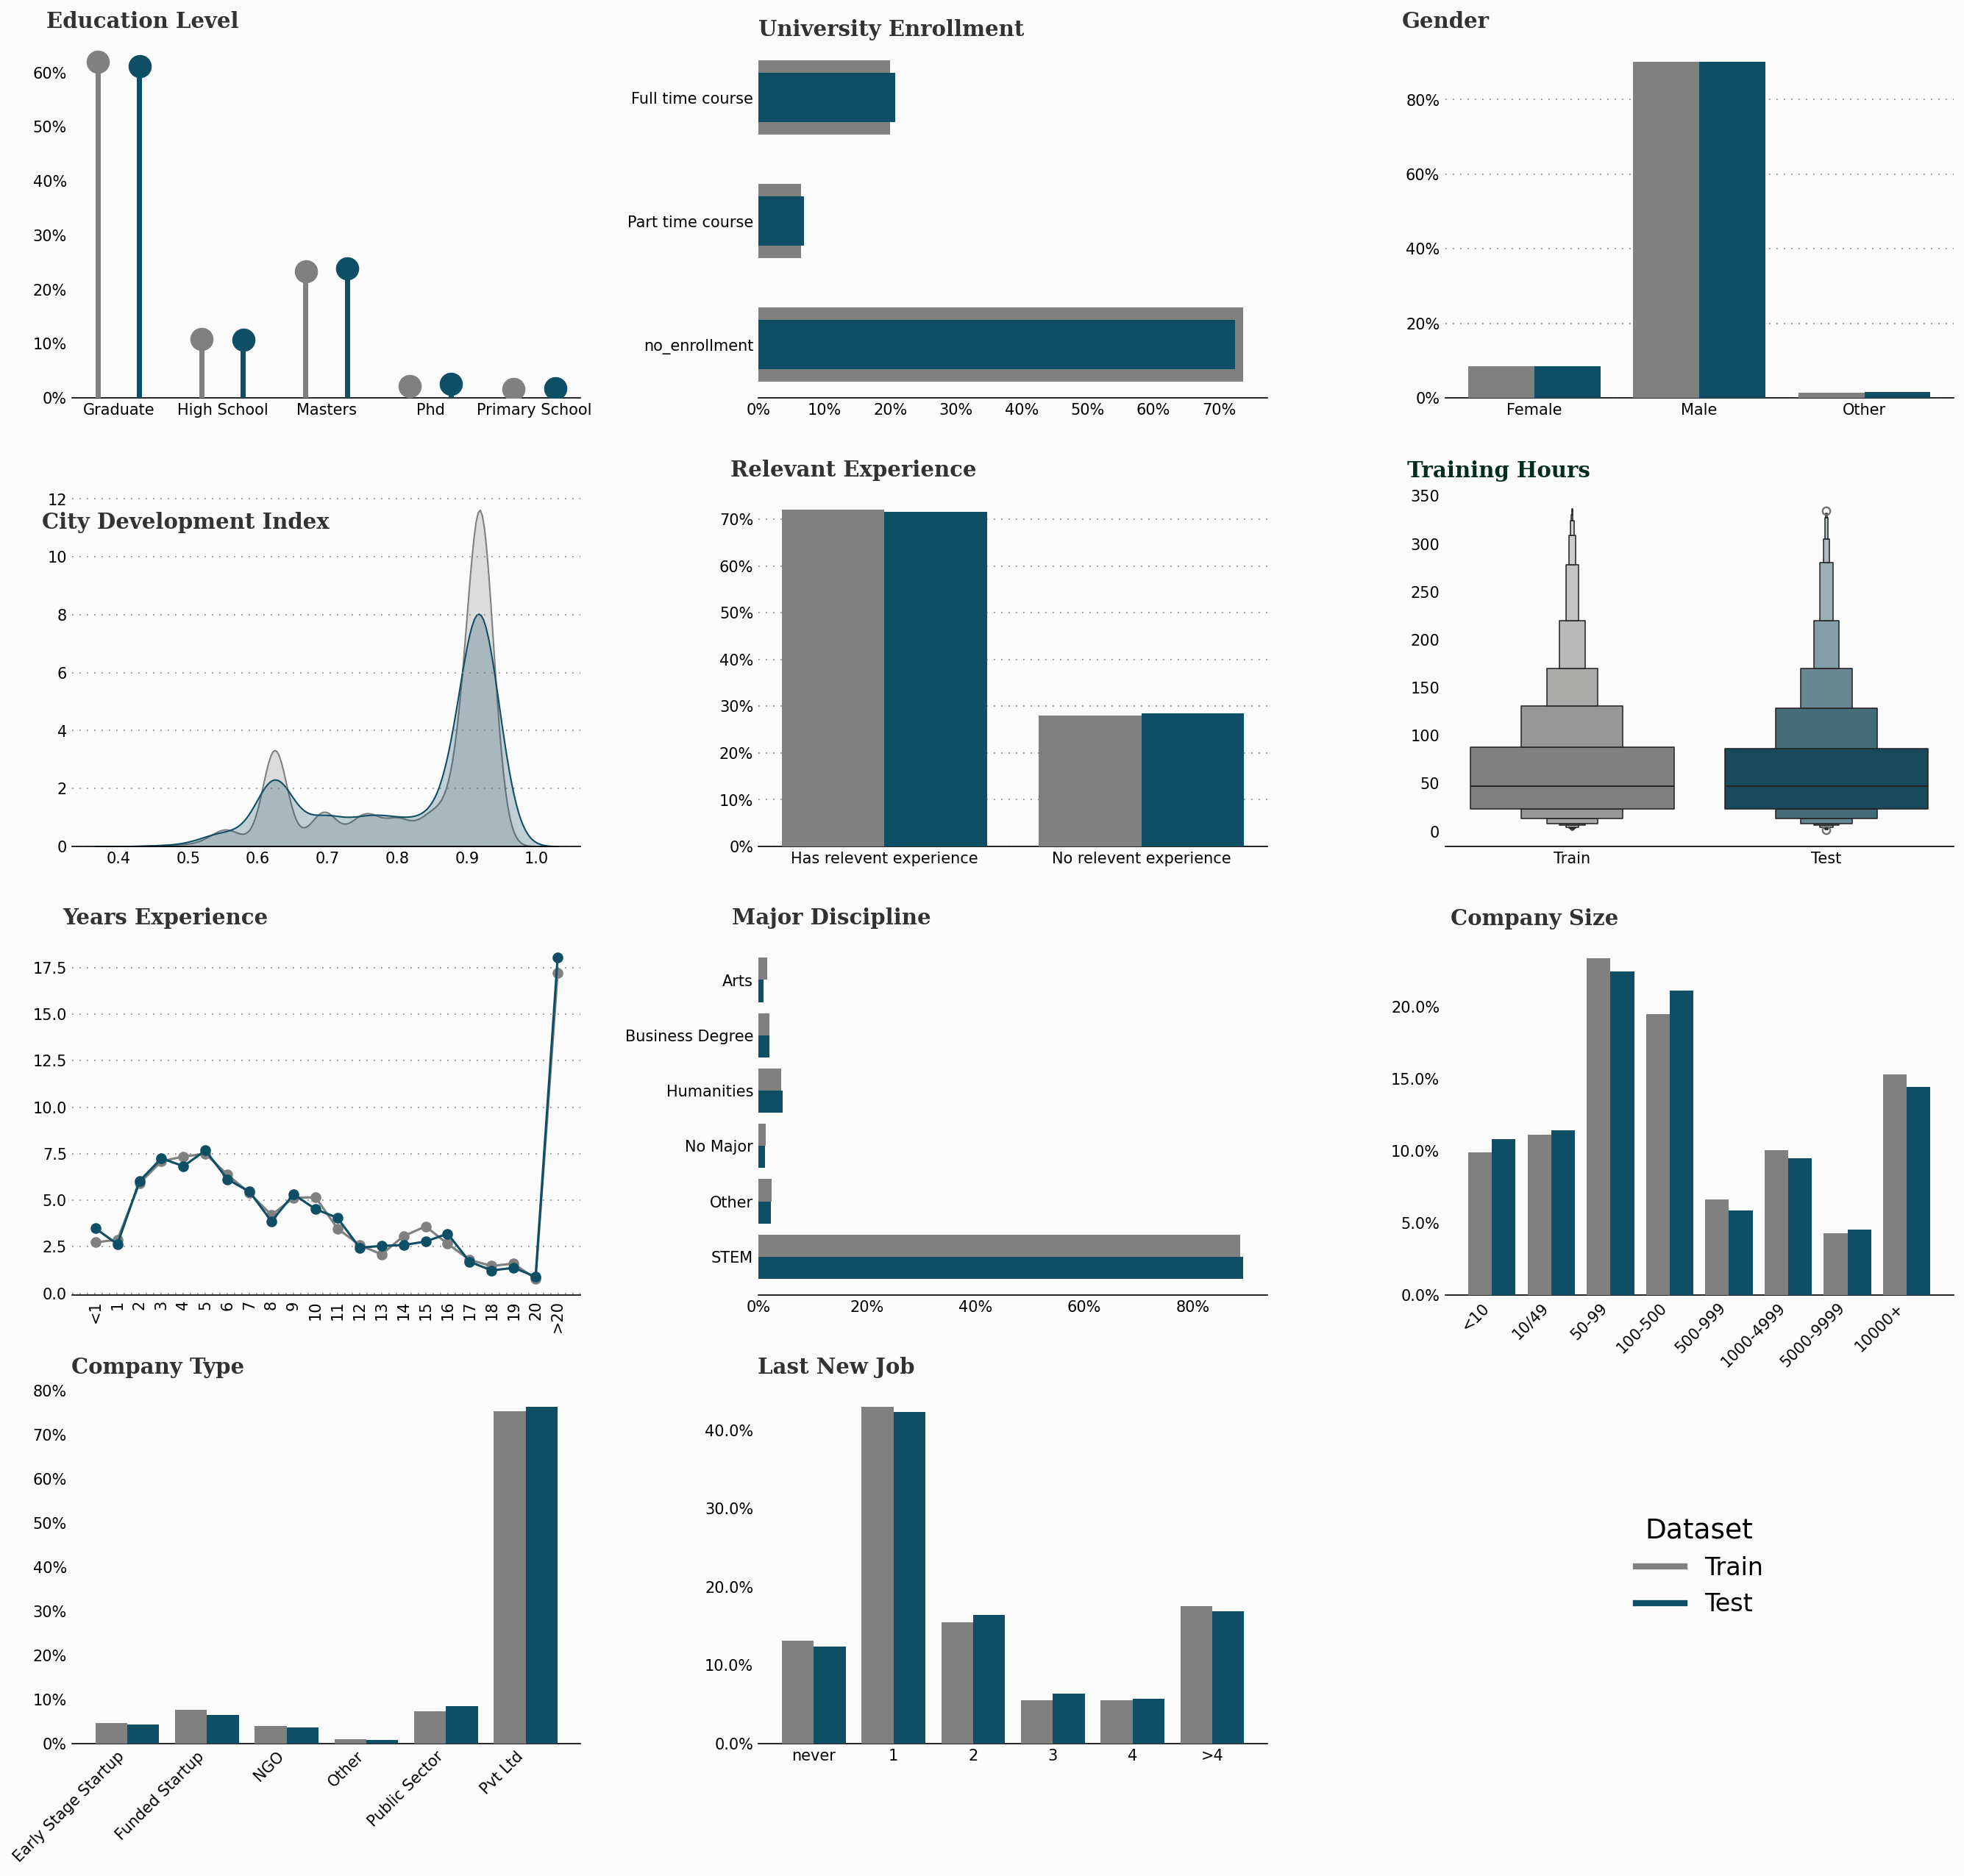

In [36]:
train_data_path = '../data/raw/aug_train.csv'
test_data_path = '../data/raw/aug_test.csv'

viz.plot_train_test_comparison(train_data_path, test_data_path)

Nhìn chung, tập train và test có phân phối rất **giống nhau** trên hầu hết các đặc trưng. Điều này cho thấy việc chia tách dữ liệu đã được thực hiện tốt, đảm bảo tính đại diện. Sau bước tiền xử lý, ta có thể an tâm huấn luyện mô hình và thử nghiệm mà không cần phải xử lý gì thêm.

# 6. Tổng kết

## 1. Các quan sát chủ chốt:
*   **Môi trường > Thâm niên:** Yếu tố địa lý (Chỉ số phát triển thành phố - CDI) có sức mạnh dự báo áp đảo. Tại các thành phố kém phát triển, tỷ lệ muốn nghỉ việc rất cao bất kể ứng viên là Junior hay Senior.
*   **Tín hiệu từ dữ liệu bị thiếu (Missing Values):** Việc thiếu thông tin ở các cột liên quan đến công ty (`company_size`, `company_type`) không phải ngẫu nhiên mà mang tính hệ thống. Nhóm "Missing" này có tỷ lệ nghỉ việc cao vượt trội, cho thấy việc che giấu thông tin công ty là một chỉ báo hành vi quan trọng.
*   **Sự phân hóa của Startup:** Không phải Startup nào cũng rủi ro. Nhóm nhân sự trình độ cao (Masters/PhD) rất gắn bó với **Funded Startup** (đã có vốn), trong khi họ rời bỏ **Early Stage Startup** rất nhiều.
*   **Vô hiệu hóa biến `training_hours`:** Số giờ đào tạo không cho thấy sự khác biệt đáng kể giữa nhóm nghỉ việc và ở lại, ngay cả khi phân tích đa biến. Đây là một đặc trưng (feature) yếu.

## 2. Về chất lượng dữ liệu:
*   **Dữ liệu thiếu (Missing Data):** Tỷ lệ thiếu cao ở `company_type` (~32%), `company_size` (~31%) và `gender` (~23%).
*   **Mất cân bằng dữ liệu (Imbalance):** Tỷ lệ Target 0:1 là khoảng 3:1. Điều này sẽ khiến mô hình thiên vị nhóm đa số (không nghỉ việc) nếu không xử lý.
*   **High Cardinality (Nhiều giá trị đơn nhất):** Cột `city` có quá nhiều giá trị (123) nhưng lại dư thừa thông tin so với `city_development_index`.
*   **Chênh lệch thang đo (Scaling):** `training_hours` (1-336) và `city_development_index` (0-1) có sự chênh lệch biên độ quá lớn.

## 3. Các câu hỏi nghiên cứu thêm:
*   **Pattern:** Nhóm Senior (>20 năm) tại các công ty rất nhỏ (<10 người) có tỷ lệ nghỉ việc thấp kỷ lục, trái ngược hoàn toàn với nhóm Junior tại cùng môi trường.
    *   *Research Question:* Liệu có phải mô hình đang nắm bắt được nhóm "Founders/Co-founders" hoặc nhóm lãnh đạo cốt cán tại các công ty gia đình? Cần thêm feature engineering để tách nhóm này ra?
*   **Pattern:** Nhóm Graduate có tỷ lệ nghỉ việc cao hơn Masters và PhD.
    *   *Research Question:* Có phải thị trường đang khát nhân lực trình độ Graduate (tầm trung) nhất, khiến họ có nhiều cơ hội nhảy việc (job hopping) hơn các nhóm trình độ quá cao hoặc quá thấp?

## 4. Một số lưu ý khác:

*   **Vấn đề nghiêm trọng:**
    Biến `training_hours` hiện tại gần như là nhiễu. Nếu đưa vào mô hình mà không qua xử lý kỹ (như binning lại thành các khoảng, hoặc kết hợp với biến khác), nó có thể làm giảm hiệu suất của các mô hình tuyến tính hoặc dựa trên khoảng cách. Vì vậy, có thể lựa chọn mô hình ít bị ảnh hưởng bới vấn đề này như Random Forest.

*   **Hạn chế:**
    *   **Thiên kiến của dữ liệu thiếu:** Việc tạo category "Missing" là tốt cho dự báo, nhưng nó làm giảm khả năng giải thích của mô hình về mặt nghiệp vụ (VD: ta biết người giấu thông tin công ty thì hay nghỉ, nhưng ta không biết *loại công ty nào* thực sự khiến họ nghỉ).
    *   **Metric đánh giá:** Do dữ liệu mất cân bằng nên không chỉ sử dụng `Accuracy` làm thước đo chính. Cần tập trung vào `F1-Score`, `Recall`, hoặc `ROC-AUC`.